<a href="https://colab.research.google.com/github/jonathanparth/I2RL-TrafficSignalOptimization/blob/main/TrafficSignalsOptimizerMVP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Install and import libaries

In [1]:
# Install libraries
!pip install traci
!pip install stable-baselines3
!pip install gymnasium
!pip install pyvirtualdisplay
!pip install libsumo
!pip install torch

# Add SUMO repository and install SUMO
!sudo add-apt-repository ppa:sumo/stable
# Install SUMO and dependencies
!sudo apt-get update
!sudo apt-get install -y sumo sumo-tools sumo-doc
# Verify SUMO installation
!sumo --version

# Imports
import gymnasium as gym
import numpy as np
import random

import os
import sys
import sumolib
import libsumo
import traci
import json
import matplotlib.pyplot as pl
import torch as th
import glob

from gymnasium import Env, spaces
from gymnasium.envs.registration import register, registry
from pathlib import Path
from typing import Callable, Optional, Tuple, Union
from pyvirtualdisplay import Display
from typing import Callable, List, Union
from stable_baselines3 import DQN
from collections import defaultdict, deque
from google.colab import files

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.2/126.2 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.9/149.9 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.8/25.8 MB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.8/72.8 MB 10.4 MB/s eta 0:00:00
Repository: 'deb https://ppa.launchpadcontent.net/sumo/stable/ubuntu/ jammy main'
Description:
SUMO is a highly portable, microscopic traffic simulation package designed to handle large road networks. SUMO is open source, licensed under the EPLv2.
More info: https://launchpad.net/~sumo/+archive/ubuntu/stable
Adding repository.
Press [ENTER] to continue or Ctrl-c to cancel.
Adding deb entry to /etc/apt/sources.list.d/sumo-ubuntu-stable-jammy.list
Adding disabled deb-src entry to /etc/apt/sources.list.d/sumo-ubuntu-s

## Setup Sumo and files
Upload SUMO network (.net.xml) and route files (.rou.xml) to Colab instance

In [4]:
# Terminate any lingering SUMO processes
!pkill -f sumo || echo "No SUMO processes to terminate."

# Define required files
required_files = ["single-intersection.net.xml", "single-intersection-horizontal.rou.xml"]

# Remove old versions of required files if they exist
for pattern in required_files:
    for file in glob.glob(pattern.split('.')[0] + "*"):
        print(f"Removing old file: {file}")
        os.remove(file)

# Prompt for file upload
print("Please upload the following files:")
print("- single-intersection.net.xml")
print("- single-intersection-horizontal.rou.xml")
uploaded = files.upload()

# Save uploaded files
for name, content in uploaded.items():
    with open(name, "wb") as f:
        f.write(content)

# Verify uploaded files
print("Uploaded files saved:", os.listdir())

# Set SUMO_HOME environment variable
os.environ["SUMO_HOME"] = "/usr/share/sumo"

# Enable Libsumo for performance boost
os.environ["LIBSUMO_AS_TRACI"] = "1"
print("Libsumo acceleration enabled.")

# Ensure SUMO tools are added to Python path
tools = os.path.join(os.environ["SUMO_HOME"], "tools")
if tools not in sys.path:
    sys.path.append(tools)
print("SUMO tools directory added to sys.path")


^C
Removing old file: single-intersection.net.xml
Removing old file: single-intersection-horizontal.rou.xml
Please upload the following files:
- single-intersection.net.xml
- single-intersection-horizontal.rou.xml


Saving single-intersection.net.xml to single-intersection.net.xml
Saving single-intersection-horizontal.rou.xml to single-intersection-horizontal.rou.xml
Uploaded files saved: ['.config', 'single-intersection.net.xml', 'single-intersection-horizontal.rou.xml', 'sample_data']
Libsumo acceleration enabled.
SUMO tools directory added to sys.path


# Setup of TrafficSignal class

In [5]:
class TrafficSignal:
    """Class to represent a traffic signal in SUMO."""

    MIN_GAP = 2.5  # Default min gap of SUMO

    def __init__(
        self,
        env,
        ts_id: str,
        delta_time: int,
        yellow_time: int,
        min_green: int,
        max_green: int,
        begin_time: int,
        reward_fn: Union[str, Callable],
        sumo,
    ):
        self.id = ts_id
        self.env = env
        self.delta_time = delta_time
        self.yellow_time = yellow_time
        self.min_green = min_green
        self.max_green = max_green
        self.green_phase = 0
        self.is_yellow = False
        self.time_since_last_phase_change = 0
        self.next_action_time = begin_time
        self.last_measure = 0.0
        self.last_reward = None
        self.reward_fn = reward_fn
        self.sumo = sumo

        # Parse reward function if it's a string
        if isinstance(self.reward_fn, str):
            if self.reward_fn in TrafficSignal.reward_fns:
                self.reward_fn = TrafficSignal.reward_fns[self.reward_fn]
            else:
                raise NotImplementedError(f"Reward function '{self.reward_fn}' is not implemented.")

        # Initialize lanes and lengths
        self.lanes = list(dict.fromkeys(self.sumo.trafficlight.getControlledLanes(self.id)))
        self.out_lanes = [
            link[0][1] for link in self.sumo.trafficlight.getControlledLinks(self.id) if link
        ]
        self.out_lanes = list(set(self.out_lanes))
        self.lanes_length = {
            lane: self.sumo.lane.getLength(lane) for lane in self.lanes + self.out_lanes
        }

        # Observation and action spaces
        self.observation_space = spaces.Box(
            low=0, high=1.0, shape=(8 + 1 + len(self.lanes) * 2,), dtype=np.float32
        )
        self.action_space = spaces.Discrete(8)

    def compute_observation(self):
        """Computes the observation for the traffic signal."""
        phase_id = [1 if self.green_phase == i else 0 for i in range(8)]
        min_green = [1 if self.time_since_last_phase_change >= self.min_green else 0]
        density = self.get_lanes_density()
        queue = self.get_lanes_queue()
        obs = np.array(phase_id + min_green + density + queue, dtype=np.float32)

        # print("Phase ID:", phase_id)
        # print("Min Green:", min_green)
        # print("Density:", density)
        # print("Queue:", queue)

        # print("Observation Length:", len(obs))  # Debugging
        # print("Observation Shape:", obs.shape)
        # print("Expected Shape:", self.observation_space.shape)

        assert len(obs) == self.observation_space.shape[0], "Observation length mismatch."
        assert self.observation_space.contains(obs), f"Observation {obs} is out of bounds."
        return obs

    def compute_reward(self):
        """Computes the reward for the traffic signal."""
        raw_reward = self.reward_fn(self)
        reward = float(raw_reward)
        # print(f"Computed Reward: {reward}, Type: {type(reward)}")  # Debug
        self.last_reward = reward
        return self.last_reward

    def set_next_phase(self, new_phase: int):
        """Sets the next green phase and optionally triggers a yellow phase."""
        valid_phases = 8

        # Ensure new_phase is an integer
        new_phase = int(new_phase)

        if new_phase < 0 or new_phase >= valid_phases:
            raise ValueError(f"Invalid phase index: {new_phase}. Must be in range [0, {valid_phases - 1}].")


        if self.green_phase == new_phase:
            self.sumo.trafficlight.setPhase(self.id, self.green_phase)
        else:
            # Trigger the yellow phase before changing to the new green phase
            yellow_phase = (self.green_phase + 1) % valid_phases
            self.sumo.trafficlight.setPhase(self.id, yellow_phase)
            self.green_phase = new_phase

        self.time_since_last_phase_change = 0

    def get_lanes_density(self) -> List[float]:
        """Returns the density of vehicles in each lane."""
        densities = []
        for lane in self.lanes:
            lane_length = self.lanes_length.get(lane, 1)
            density = self.sumo.lane.getLastStepVehicleNumber(lane) / lane_length
            densities.append(min(1.0, density))
        return densities

    def get_lanes_queue(self) -> List[float]:
        """Returns the queue [0, 1] of vehicles in the lanes."""
        queues = []
        for lane in self.lanes:
            lane_length = self.lanes_length.get(lane, 1)
            queue = self.sumo.lane.getLastStepHaltingNumber(lane) / lane_length
            queues.append(min(1.0, queue))
        return queues

    def set_reward_fn(self, new_reward_fn: Union[str, Callable]):
        """Dynamically set the reward function."""
        if isinstance(new_reward_fn, str):
            if new_reward_fn in TrafficSignal.reward_fns:
                self.reward_fn = TrafficSignal.reward_fns[new_reward_fn]
            else:
                raise NotImplementedError(f"Reward function '{new_reward_fn}' is not implemented.")
        elif callable(new_reward_fn):
            self.reward_fn = new_reward_fn
        else:
            raise ValueError("Reward function must be a string or callable.")

    def get_pressure(self):
        """Returns the pressure (#veh leaving - #veh approaching) of the intersection."""
        return sum(self.sumo.lane.getLastStepVehicleNumber(lane) for lane in self.out_lanes) - sum(
            self.sumo.lane.getLastStepVehicleNumber(lane) for lane in self.lanes
        )

    @staticmethod
    def combined_reward(ts, weights):
        """Improved reward function combining multiple objectives with configurable weights."""
        # Weights for different components
        w_waiting = weights.get("waiting_penalty", 0.2)
        w_queue = weights.get("queue_penalty", 0.1)
        w_flow = weights.get("flow_reward", 5.0)
        w_balance = weights.get("balance_penalty", 0.1)
        w_change = weights.get("change_penalty", 1.0)

        # Components of the reward
        waiting_penalty = -w_waiting * sum(ts.sumo.lane.getWaitingTime(lane) for lane in ts.lanes)
        queue_penalty = -w_queue * sum(ts.sumo.lane.getLastStepHaltingNumber(lane) for lane in ts.lanes)
        flow_reward = w_flow * (ts.get_pressure() / len(ts.lanes))
        lane_queues = ts.get_lanes_queue()
        balance_penalty = -w_balance * abs(sum(lane_queues[:len(lane_queues)//2]) - sum(lane_queues[len(lane_queues)//2:]))
        change_penalty = -w_change if ts.time_since_last_phase_change < ts.min_green else 0

        # Combined reward
        total_reward = waiting_penalty + queue_penalty + flow_reward + balance_penalty + change_penalty
        return total_reward

    # Static dictionary of reward functions
    reward_fns = {
        "diff-waiting-time": lambda ts: -sum(ts.sumo.lane.getWaitingTime(lane) for lane in ts.lanes),
        "queue": lambda ts: -sum(ts.sumo.lane.getLastStepHaltingNumber(lane) for lane in ts.lanes),
        "pressure": lambda ts: sum(ts.sumo.lane.getLastStepVehicleNumber(lane) for lane in ts.out_lanes) -
                              sum(ts.sumo.lane.getLastStepVehicleNumber(lane) for lane in ts.lanes),
        "combined": lambda ts: TrafficSignal.combined_reward(ts, weights={
            "waiting_penalty": 0.2,
            "queue_penalty": 0.1,
            "flow_reward": 5.0,
            "balance_penalty": 0.1,
            "change_penalty": 1.0,
        }),
    }

# 2. Define Environment


In [6]:
class SumoSingleIntersectionEnv(Env):
    """SUMO Environment for Single Intersection."""

    def __init__(
        self,
        net_file: str,
        route_file: str,
        use_gui: bool = False,
        delta_time: int = 5,
        reward_fn: str = "combined",
        max_steps: int = 1000,
        yellow_time: int = 3,
        min_green: int = 10,
        max_green: int = 50,
    ):
        # File paths and settings
        self.net_file = net_file
        self.route_file = route_file
        self.use_gui = use_gui
        self.delta_time = delta_time
        self.reward_fn = reward_fn
        self.max_steps = max_steps
        self.yellow_time = yellow_time
        self.min_green = min_green
        self.max_green = max_green

        # SUMO setup
        self.libsumo_enabled = "LIBSUMO_AS_TRACI" in os.environ
        self.sumo_cmd = ["sumo-gui" if use_gui else "sumo", "-n", net_file, "-r", route_file, "--no-warnings", "--start",
            "--window-size", "800,600",
            "--duration-log.statistics",
            "--max-depart-delay", "100000"]

        # print(f"SUMO Command: {' '.join(self.sumo_cmd)}")
        # print(f"Network file exists: {os.path.exists(net_file)}")
        # print(f"Route file exists: {os.path.exists(route_file)}")
        self.sumo = None

        # TrafficSignal initialization
        self.traffic_signal = None

        # Placeholder spaces to satisfy Gymnasium's requirements
        self.action_space = spaces.Discrete(8)
        self.observation_space = spaces.Box(low=0, high=1.0, shape=(25,), dtype=np.float32)

    def reset(self, seed: Optional[int] = None, options: Optional[dict] = None):
        """Reset the SUMO simulation and initialize TrafficSignal."""
        if self.sumo is not None:
            libsumo.close() if self.libsumo_enabled else traci.close()
        self.sumo = libsumo if self.libsumo_enabled else traci
        self.sumo.start(self.sumo_cmd)

        self.sim_step = 0
        self.traffic_signal = TrafficSignal(
            env=self,
            ts_id=self.sumo.trafficlight.getIDList()[0],
            delta_time=self.delta_time,
            yellow_time=self.yellow_time,
            min_green=self.min_green,
            max_green=self.max_green,
            begin_time=0,
            reward_fn=TrafficSignal.reward_fns[self.reward_fn],
            sumo=self.sumo,
        )

         # Set observation_space dynamically
        if self.observation_space is None:
            self.observation_space = self.traffic_signal.observation_space

        observation = self.traffic_signal.compute_observation()
        observation = np.array(observation, dtype=np.float32)

        return observation, {}


    def step(self, action: int):
        """Take a step in the environment."""
        self.traffic_signal.set_next_phase(action)
        for _ in range(self.delta_time):
            self.sumo.simulationStep()
            self.sim_step += 1
            self.traffic_signal.time_since_last_phase_change += 1

        obs = self.traffic_signal.compute_observation()
        obs = np.array(obs, dtype=np.float32)
        reward = float(self.traffic_signal.compute_reward())
        terminated = self.sim_step >= self.max_steps
        truncated = False
        info = {}

        # Debugging checks
        assert isinstance(obs, np.ndarray) and obs.dtype == np.float32, "Observation must be np.float32"
        assert isinstance(reward, float), "Reward must be a float"
        assert isinstance(terminated, bool) and isinstance(truncated, bool), "Terminated and truncated must be bool"

        return obs, reward, terminated, truncated, info


    def get_metrics(self):
        """Compute traffic metrics."""
        vehicles = self.sumo.vehicle.getIDList()
        waiting_times = [self.sumo.vehicle.getWaitingTime(veh) for veh in vehicles]
        avg_waiting_time = np.mean(waiting_times) if waiting_times else 0
        throughput = len(vehicles)
        return avg_waiting_time, throughput

    def close(self):
        """Close the SUMO simulation."""
        if self.sumo:
            libsumo.close() if self.libsumo_enabled else traci.close()

    def render(self, mode="human"):
        """
        Render the SUMO simulation using SUMO-GUI.
        If the mode is 'human', the GUI will display the current state.
        """
        if mode != "human":
            raise NotImplementedError("Only 'human' mode is supported for rendering.")

        if self.use_gui and self.sumo is not None:
            print("SUMO-GUI is already running. Updating the view...")
        elif not self.use_gui:
            raise ValueError("Cannot render SUMO-GUI when 'use_gui' is set to False.")
        else:
            print("SUMO-GUI is not running. Make sure 'use_gui=True' at environment initialization.")

### Register environment

In [7]:

# Check if Libsumo is enabled
print("Libsumo enabled:", "LIBSUMO_AS_TRACI" in os.environ)

# Register the environment only if not already registered
if "sumo-single-intersection-RL" not in registry:
    register(
        id="sumo-single-intersection-RL",
        entry_point="__main__:SumoSingleIntersectionEnv",
    )

# Create environment
env = gym.make(
    "sumo-single-intersection-RL",
    net_file="single-intersection.net.xml",
    route_file="single-intersection-horizontal.rou.xml",
    max_steps=1000,
)

# Test environment
try:
    obs, info = env.reset()
    print("Environment initialized. Initial observation:", obs)
    for _ in range(1000):
        action = env.action_space.sample()  # Random action
        print(f"Selected action: {action}")
        obs, reward, terminated, truncated, info = env.step(action)
        print(f"Step: Observation={obs}, Reward={reward}, Terminated={terminated}")
        if terminated or truncated:
            break
finally:
    env.close()
    print("Environment closed successfully.")


Libsumo enabled: True
SUMO Command: sumo -n single-intersection.net.xml -r single-intersection-horizontal.rou.xml --no-warnings --start --window-size 800,600 --duration-log.statistics --max-depart-delay 100000
Network file exists: True
Route file exists: True
Environment initialized. Initial observation: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
Selected action: 2
Step: Observation=[0.         0.         1.         0.         0.         0.
 0.         0.         0.         0.01408947 0.00704473 0.01408947
 0.00704473 0.01408947 0.00704473 0.01408947 0.00704473 0.
 0.         0.         0.         0.         0.         0.
 0.        ], Reward=-8.5, Terminated=False
Selected action: 0
Step: Observation=[1.         0.         0.         0.         0.         0.
 0.         0.         0.         0.01408947 0.00704473 0.01408947
 0.00704473 0.01408947 0.00704473 0.01408947 0.00704473 0.
 0.         0.         0.         0.         0.         0.
 0.       

# 3. Implement Algorithms



## Fixed-Timing Benchmark

In [8]:
import json

# Fixed-timing benchmark function
def fixed_timing_benchmark(env, ns_time=30, we_time=30):
    """Evaluate fixed-timing traffic signals and return total reward."""
    state, _ = env.reset()
    done = False
    total_reward = 0
    cycle = [0, 1]
    time_in_phase = 0
    phase_idx = 0

    while not done:
        if time_in_phase >= (ns_time if cycle[phase_idx] == 0 else we_time):
            phase_idx = (phase_idx + 1) % len(cycle)  # Switch to next phase
            time_in_phase = 0
        action = cycle[phase_idx]
        _, reward, terminated, truncated, _ = env.step(action)
        total_reward += reward
        time_in_phase += env.delta_time

        # Check if simulation has ended
        done = terminated or truncated

    # Return the reward and metrics
    avg_waiting_time, throughput = env.get_metrics()
    return total_reward, avg_waiting_time, throughput

# Evaluate fixed-time benchmark
fixed_timing_results = {}

reward_functions = TrafficSignal.reward_fns

for reward_fn in reward_functions.keys():
    print(f"Evaluating Fixed-Timing Policy for Reward Function: {reward_fn}")
    env = SumoSingleIntersectionEnv(
        net_file="single-intersection.net.xml",
        route_file="single-intersection-horizontal.rou.xml",
        use_gui=False,
        max_steps=1000,
        reward_fn=reward_fn,
    )

    total_rewards = []
    waiting_times = []
    throughputs = []

    for _ in range(10):
        fixed_reward, avg_waiting_time, throughput = fixed_timing_benchmark(env, ns_time=30, we_time=30)
        total_rewards.append(fixed_reward)
        waiting_times.append(avg_waiting_time)
        throughputs.append(throughput)

    env.close()

    # Calculate averages
    average_reward = sum(total_rewards) / len(total_rewards)
    average_waiting_time = sum(waiting_times) / len(waiting_times)
    average_throughput = sum(throughputs) / len(throughputs)

    print(f"Fixed-Timing Overall Average Reward for {reward_fn}: {average_reward:.2f}")
    print(f"Fixed-Timing Average Waiting Time for {reward_fn}: {average_waiting_time:.2f}")
    print(f"Fixed-Timing Throughput for {reward_fn}: {average_throughput:.2f}")
    print()

    fixed_timing_results[reward_fn] = {
        "overall_avg_reward": average_reward,
        "avg_waiting_time": average_waiting_time,
        "avg_throughput": average_throughput,
    }

# Save fixed-timing results
with open("fixed_timing_results.json", "w") as f:
    json.dump(fixed_timing_results, f, indent=4)

print("Fixed-timing benchmark results saved.")


Evaluating Fixed-Timing Policy for Reward Function: diff-waiting-time
SUMO Command: sumo -n single-intersection.net.xml -r single-intersection-horizontal.rou.xml --no-warnings --start --window-size 800,600 --duration-log.statistics --max-depart-delay 100000
Network file exists: True
Route file exists: True
Fixed-Timing Overall Average Reward for diff-waiting-time: -1768994.00
Fixed-Timing Average Waiting Time for diff-waiting-time: 52.78
Fixed-Timing Throughput for diff-waiting-time: 82.00

Evaluating Fixed-Timing Policy for Reward Function: queue
SUMO Command: sumo -n single-intersection.net.xml -r single-intersection-horizontal.rou.xml --no-warnings --start --window-size 800,600 --duration-log.statistics --max-depart-delay 100000
Network file exists: True
Route file exists: True
Fixed-Timing Overall Average Reward for queue: -13629.00
Fixed-Timing Average Waiting Time for queue: 52.78
Fixed-Timing Throughput for queue: 82.00

Evaluating Fixed-Timing Policy for Reward Function: pressu

## Exploration Strategy

In [ ]:
class EpsilonGreedy:
    """Epsilon-Greedy exploration strategy."""
    def __init__(self, initial_epsilon=1.0, min_epsilon=0.1, decay=0.99):
        self.epsilon = initial_epsilon
        self.min_epsilon = min_epsilon
        self.decay = decay

    def choose(self, q_table, state, action_space):
        if np.random.rand() < self.epsilon:
            return action_space.sample()  # Explore
        else:
            return np.argmax(q_table.get(state, [0 for _ in range(action_space.n)]))  # Exploit

    def decay_epsilon(self):
        self.epsilon = max(self.min_epsilon, self.epsilon * self.decay)

## 3.1 Q-Learning


In [ ]:
class QLAgent:
    """Q-Learning Agent class."""

    def q_table_to_dict(self):
        """Convert Q-table to a regular dictionary for JSON saving."""
        return {str(k): v for k, v in self.q_table.items()}  # Convert keys to strings

    def q_table_from_dict(self, q_table_dict):
        """Reconstruct Q-table from a JSON-compatible dictionary."""
        self.q_table = {eval(k): v for k, v in q_table_dict.items()}  # Convert keys back to tuples

    def __init__(self, starting_state, state_space, action_space, alpha=0.5, gamma=0.95, exploration_strategy=None, decay_rate=0.95):
        self.state = tuple(starting_state) if starting_state is not None else ()
        self.state_space = state_space
        self.action_space = action_space
        self.action = None
        self.alpha = alpha
        self.gamma = gamma
        self.decay_rate = decay_rate
        self.q_table = {}
        self.exploration = exploration_strategy
        self.acc_reward = 0

    def act(self):
        """Select an action using the epsilon-greedy strategy."""
        self.action = self.exploration.choose(self.q_table, self.state, self.action_space)
        return self.action

    def learn(self, next_state, reward, done=False):
        """Update the Q-value using the Bellman equation."""
        s = self.state
        s1 = tuple(next_state)
        a = self.action
        if s not in self.q_table:
            self.q_table[s] = [0] * self.action_space.n
        if s1 not in self.q_table:
            self.q_table[s1] = [0] * self.action_space.n
        max_future_q = max(self.q_table[s1]) if not done else 0
        self.q_table[s][a] += self.alpha * (reward + self.gamma * max_future_q - self.q_table[s][a])
        self.state = s1

    def decay_learning_rate(self, min_alpha=0.01, decay_rate=None):
        """Decay learning rate dynamically."""
        if decay_rate is None:
            decay_rate = self.decay_rate
        self.alpha = max(min_alpha, self.alpha * decay_rate)

    def reset_accumulated_reward(self):
        """Reset accumulated reward (useful for episodic logging)."""
        self.acc_reward = 0

    def greedy_act(self):
        """Select the action with the highest Q-value for the current state."""
        if self.state in self.q_table:
            return self.q_table[self.state].index(max(self.q_table[self.state]))
        else:
            return random.choice(range(self.action_space.n))


### Random Search for optimal hyperparameters

In [ ]:
# Define search space for hyperparameters
hyperparameter_space = {
    "alpha": [0.45, 0.5, 0.55],  # Learning rate range
    "gamma": [0.75, 0.8, 0.85],  # Discount factor range
    "epsilon": [0.99, 0.995, 1.0],  # Initial exploration rate range
    "min_epsilon": [0.025, 0.03, 0.035],  # Minimum epsilon range
    "epsilon_decay": [0.98, 0.985, 0.99],  # Epsilon decay rate range
    "decay_rate": [0.95, 0.99, 0.995],  # Learning rate decay
    "min_alpha": [0.045, 0.05, 0.055],  # Minimum alpha range
}

# Number of random search trials per reward function
n_trials = 10

# List of reward functions to optimize
reward_functions = ["diff-waiting-time", "queue", "pressure", "combined"]


# Results dictionary to track performance
results = {
    reward_fn: {
        "best_hyperparams": None,
        "best_avg_reward": -float("inf"),
        "best_avg_waiting_time": float("inf"),
        "best_throughput": 0,
    }
    for reward_fn in reward_functions
}

def sample_hyperparameters(space):
    """Randomly sample hyperparameters from the defined discrete search space."""
    return {key: random.choice(values) for key, values in space.items()}

def evaluate_hyperparameters(reward_fn, hyperparams, n_episodes=150):
    """Train and evaluate an agent with given hyperparameters."""
    env = SumoSingleIntersectionEnv(
        net_file="single-intersection.net.xml",
        route_file="single-intersection-horizontal.rou.xml",
        use_gui=False,
        max_steps=1000,
        reward_fn=reward_fn,
    )
    try:
        initial_state, _ = env.reset()
        agent = QLAgent(
            starting_state=tuple(initial_state),
            state_space=env.observation_space,
            action_space=env.action_space,
            alpha=hyperparams["alpha"],
            gamma=hyperparams["gamma"],
            exploration_strategy=EpsilonGreedy(
                initial_epsilon=hyperparams["epsilon"],
                min_epsilon=hyperparams["min_epsilon"],
                decay=hyperparams["epsilon_decay"],
            ),
        )
        rewards = []
        avg_waiting_times = []
        throughputs = []

        for _ in range(n_episodes):
            state, _ = env.reset()
            agent.state = tuple(state)
            terminated = False
            truncated = False
            total_reward = 0

            while not (terminated or truncated):
                action = agent.act()
                next_state, reward, terminated, truncated, _ = env.step(action)
                agent.learn(next_state=tuple(next_state), reward=reward, done=terminated)
                total_reward += reward

            # Get metrics after the episode
            avg_waiting_time, throughput = env.get_metrics()
            avg_waiting_times.append(avg_waiting_time)
            throughputs.append(throughput)
            rewards.append(total_reward)

            # Decay learning rate
            agent.decay_learning_rate(min_alpha=hyperparams["min_alpha"], decay_rate=hyperparams["decay_rate"])

        # Aggregate results
        avg_reward = sum(rewards) / len(rewards)
        avg_waiting_time = sum(avg_waiting_times) / len(avg_waiting_times)
        avg_throughput = sum(throughputs) / len(throughputs)

        return avg_reward, avg_waiting_time, avg_throughput
    finally:
        env.close()

for reward_fn in reward_functions:
    print(f"Performing random search for reward function: {reward_fn}")
    for trial in range(n_trials):
        hyperparams = sample_hyperparameters(hyperparameter_space)
        avg_reward, avg_waiting_time, avg_throughput = evaluate_hyperparameters(reward_fn, hyperparams)

        print(
            f"Trial {trial + 1}/{n_trials}: {hyperparams} -> "
            f"Avg Reward: {avg_reward:.2f}, Avg Waiting Time: {avg_waiting_time:.2f}, Throughput: {avg_throughput: .2f}"
        )

        # Update best hyperparameters based on average reward
        if avg_reward > results[reward_fn]["best_avg_reward"]:
            results[reward_fn]["best_avg_reward"] = avg_reward
            results[reward_fn]["best_hyperparams"] = hyperparams
            results[reward_fn]["best_avg_waiting_time"] = avg_waiting_time
            results[reward_fn]["best_throughput"] = avg_throughput

# Display final results
for reward_fn, data in results.items():
    print(f"Reward Function: {reward_fn}")
    print(f"Best Hyperparameters: {data['best_hyperparams']}")
    print(f"Best Average Reward: {data['best_avg_reward']:.2f}")
    print(f"Best Avg Waiting Time: {data['best_avg_waiting_time']:.2f}")
    print(f"Best Throughput: {data['best_throughput']}")


Performing random search for reward function: combined


KeyboardInterrupt: 

### QLearning Training


Training with reward function: diff-waiting-time
Episode 50: Avg Reward (Last 50 Episodes) = -107703.22, Improvement = 93.91%
Episode 100: Avg Reward (Last 50 Episodes) = -102849.26, Improvement = 94.19%
Learning plateau detected at Episode 138. Stopping early.
Final Average Reward for diff-waiting-time: -105477.86
Overall Improvement for Q-Learning (diff-waiting-time): 94.04%


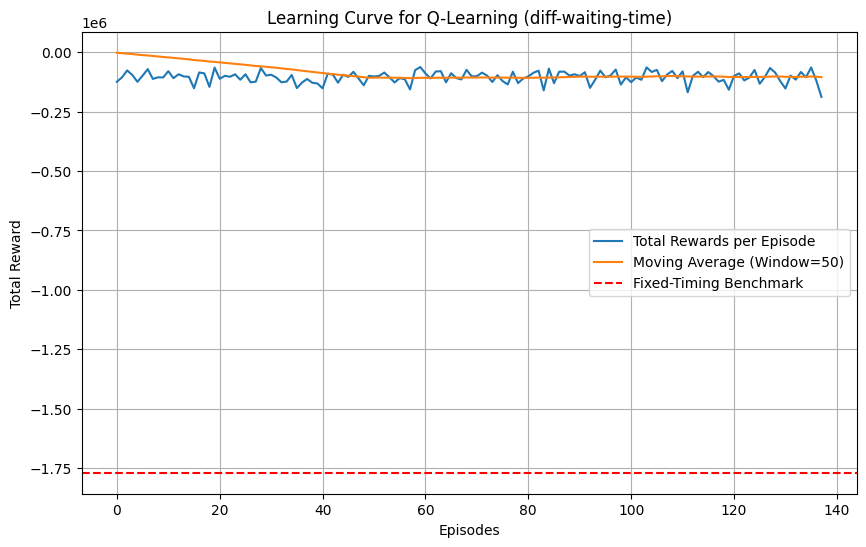



Training with reward function: queue
Episode 50: Avg Reward (Last 50 Episodes) = -6604.60, Improvement = 51.54%
Episode 100: Avg Reward (Last 50 Episodes) = -6416.52, Improvement = 52.92%
Learning plateau detected at Episode 139. Stopping early.
Final Average Reward for queue: -6498.17
Overall Improvement for Q-Learning (queue): 52.32%


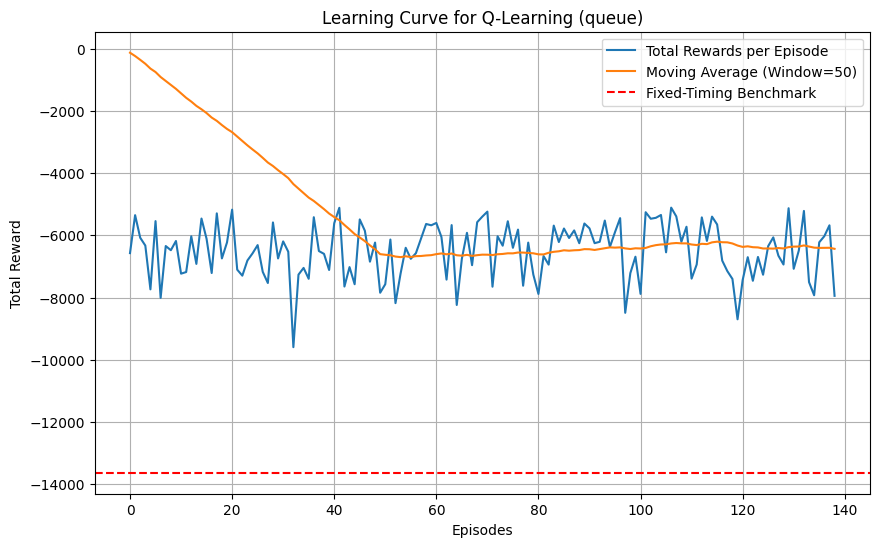



Training with reward function: pressure
Episode 50: Avg Reward (Last 50 Episodes) = -10075.88, Improvement = 29.20%
Episode 100: Avg Reward (Last 50 Episodes) = -10412.14, Improvement = 26.83%
Learning plateau detected at Episode 100. Stopping early.
Final Average Reward for pressure: -10244.01
Overall Improvement for Q-Learning (pressure): 28.02%


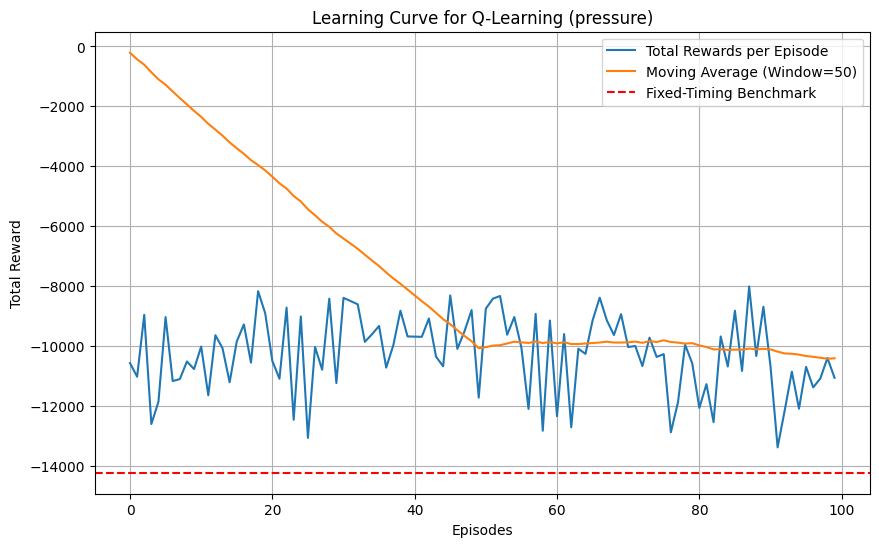



Training with reward function: combined
Episode 50: Avg Reward (Last 50 Episodes) = -28495.24, Improvement = 92.18%
Episode 100: Avg Reward (Last 50 Episodes) = -28377.69, Improvement = 92.21%
Learning plateau detected at Episode 100. Stopping early.
Final Average Reward for combined: -28436.47
Overall Improvement for Q-Learning (combined): 92.19%


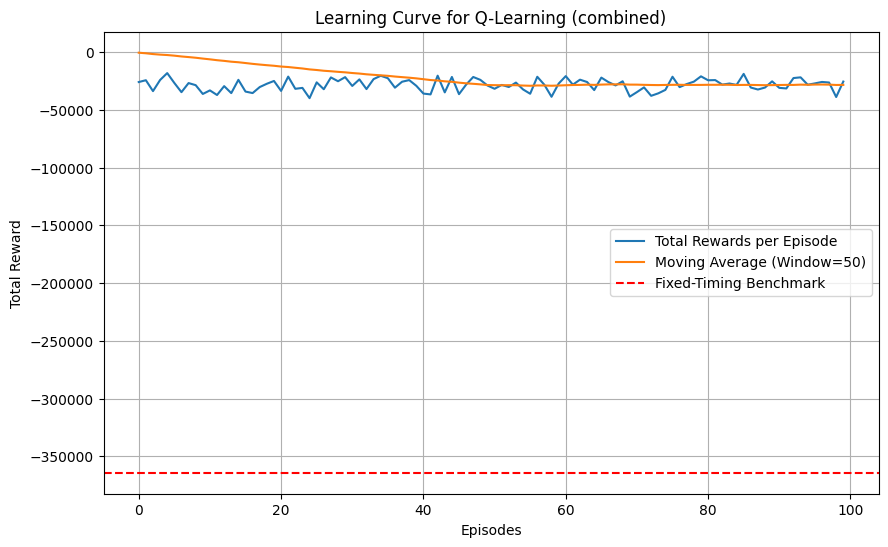



Q-Learning results saved in JSON format.


In [ ]:
import json
import matplotlib.pyplot as plt
from collections import deque

# Define QLearning reward-specific hyperparameters, including decay_rate and min_alpha
reward_functions = {
    "diff-waiting-time": {"alpha": 0.7, "gamma": 0.85, "epsilon": 1.0, "min_epsilon": 0.04, "epsilon_decay": 0.99, "decay_rate": 0.9, "min_alpha": 0.02},
    "queue": {"alpha": 0.6, "gamma": 0.9, "epsilon": 1, "min_epsilon": 0.01, "epsilon_decay": 0.985, "decay_rate": 0.99, "min_alpha": 0.05},
    "pressure": {"alpha": 0.45, "gamma": 0.9, "epsilon": 0.9, "min_epsilon": 0.01, "epsilon_decay": 0.985, "decay_rate": 0.99, "min_alpha": 0.04},
    "combined": {"alpha": 0.5, "gamma": 0.75, "epsilon": 1.0, "min_epsilon": 0.03, "epsilon_decay": 0.99, "decay_rate": 0.95, "min_alpha": 0.055},
}

ql_results = {reward_fn: {"rewards": [], "q_table": None} for reward_fn in reward_functions}

# Moving average window size
window_size = 50
plateau_threshold = 1.0  # Threshold for improvement detection (1%)

for reward_fn, hyperparams in reward_functions.items():
    print(f"Training with reward function: {reward_fn}")

    env = SumoSingleIntersectionEnv(
        net_file="single-intersection.net.xml",
        route_file="single-intersection-horizontal.rou.xml",
        use_gui=False,
        max_steps=1000,
        reward_fn=reward_fn,
    )
    initial_state, _ = env.reset()
    agent = QLAgent(
        starting_state=tuple(initial_state),
        state_space=env.observation_space,
        action_space=env.action_space,
        alpha=hyperparams["alpha"],
        gamma=hyperparams["gamma"],
        exploration_strategy=EpsilonGreedy(
            initial_epsilon=hyperparams["epsilon"],
            min_epsilon=hyperparams["min_epsilon"],
            decay=hyperparams["epsilon_decay"],
        ),
        decay_rate=hyperparams["decay_rate"],
    )

    total_rewards = []
    moving_avg_rewards = deque(maxlen=window_size)

    for episode in range(500):  # Number of episodes
        state, _ = env.reset()
        agent.state = tuple(state)
        terminated = False
        truncated = False
        total_reward = 0

        while not (terminated or truncated):
            action = agent.act()
            next_state, reward, terminated, truncated, _ = env.step(action)
            agent.learn(next_state=tuple(next_state), reward=reward, done=terminated)
            total_reward += reward

        # Save total reward and metrics
        total_rewards.append(total_reward)
        moving_avg_rewards.append(total_reward)
        avg_waiting_time, throughput = env.get_metrics()
        if "metrics" not in ql_results[reward_fn]:
            ql_results[reward_fn]["metrics"] = []
        ql_results[reward_fn]["metrics"].append({"avg_waiting_time": avg_waiting_time, "throughput": throughput})

        # Apply learning rate decay
        agent.decay_learning_rate(min_alpha=hyperparams["min_alpha"])

        # Log progress every 50 episodes
        if (episode + 1) % 50 == 0:
            avg_reward = sum(total_rewards[-50:]) / 50
            improvement = ((avg_reward - fixed_timing_results[reward_fn]) / abs(fixed_timing_results[reward_fn])) * 100
            print(f"Episode {episode + 1}: Avg Reward (Last 50 Episodes) = {avg_reward:.2f}, Improvement = {improvement:.2f}%")

        # Check for plateau
        if len(moving_avg_rewards) == window_size:
            avg_last_window = sum(moving_avg_rewards) / window_size
            avg_previous_window = sum(total_rewards[-2 * window_size:-window_size]) / window_size if len(total_rewards) >= 2 * window_size else -float('inf')
            improvement = (avg_last_window - avg_previous_window) / abs(avg_previous_window) * 100 if avg_previous_window != 0 else 0
            if improvement < plateau_threshold:
                print(f"Learning plateau detected at Episode {episode + 1}. Stopping early.")
                break

    # Calculate overall results
    overall_avg_reward = sum(total_rewards) / len(total_rewards)
    overall_improvement = ((overall_avg_reward - fixed_timing_results[reward_fn]) / abs(fixed_timing_results[reward_fn])) * 100
    avg_waiting_time = sum(m["avg_waiting_time"] for m in ql_results[reward_fn]["metrics"]) / len(ql_results[reward_fn]["metrics"])
    avg_throughput = sum(m["throughput"] for m in ql_results[reward_fn]["metrics"]) / len(ql_results[reward_fn]["metrics"])

    # Save results
    ql_results[reward_fn]["overall_avg_reward"] = overall_avg_reward
    ql_results[reward_fn]["overall_improvement"] = overall_improvement
    ql_results[reward_fn]["avg_waiting_time"] = avg_waiting_time
    ql_results[reward_fn]["avg_throughput"] = avg_throughput
    ql_results[reward_fn]["q_table"] = agent.q_table_to_dict()

    print(f"Final Average Reward for {reward_fn}: {overall_avg_reward:.2f}")
    print(f"Overall Improvement for Q-Learning ({reward_fn}): {overall_improvement:.2f}%")
    env.close()

    # Plot results
    plt.figure(figsize=(10, 6))
    plt.plot(total_rewards, label="Total Rewards per Episode")
    plt.plot(
        [sum(total_rewards[max(0, i - window_size):i]) / window_size for i in range(1, len(total_rewards) + 1)],
        label=f"Moving Average (Window={window_size})",
    )
    plt.axhline(y=fixed_timing_results[reward_fn], color="red", linestyle="--", label="Fixed-Timing Benchmark")
    plt.title(f"Learning Curve for Q-Learning ({reward_fn})")
    plt.xlabel("Episodes")
    plt.ylabel("Total Reward")
    plt.legend()
    plt.grid(True)
    plt.show()
    print("\n")

# Save Q-Learning results as JSON
with open("ql_results.json", "w") as f:
    json.dump(ql_results, f, indent=4)
print("Q-Learning results saved in JSON format.")


Once the training loop finishes, evaluate the agent by setting epsilon
= 0 (no exploration). exploits the learned Q-values (optimal actions) without exploration. This tests how well the agent performs using its final Q-table.

Evaluating greedy policy for reward function: diff-waiting-time
Evaluation Results for diff-waiting-time:
Average Reward: -108836.50
Average Waiting Time: 7.94
Average Throughput: 74.90



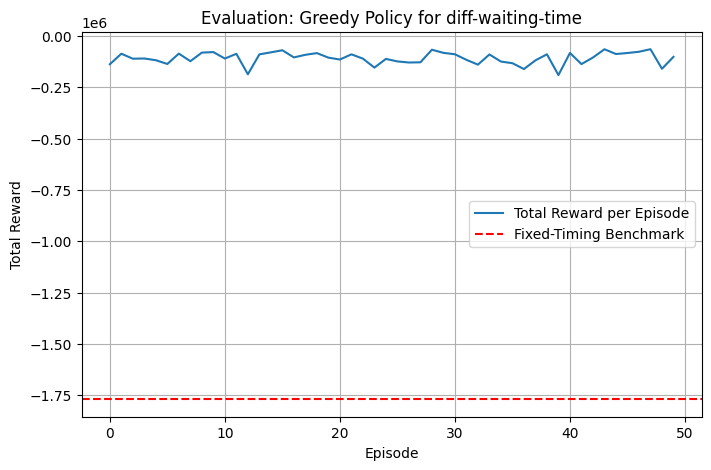

Evaluating greedy policy for reward function: queue
Evaluation Results for queue:
Average Reward: -6490.92
Average Waiting Time: 9.37
Average Throughput: 75.46



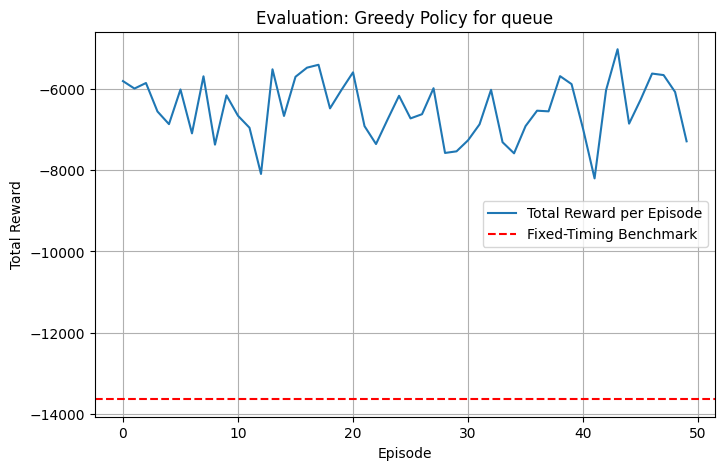

Evaluating greedy policy for reward function: pressure
Evaluation Results for pressure:
Average Reward: -10022.82
Average Waiting Time: 9.07
Average Throughput: 74.84



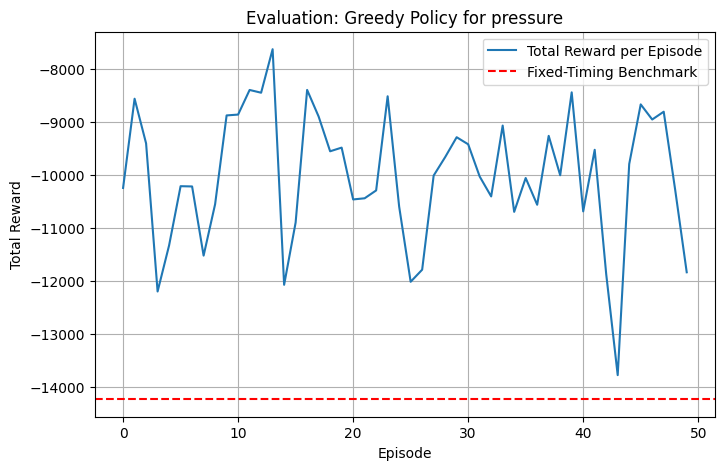

Evaluating greedy policy for reward function: combined
Evaluation Results for combined:
Average Reward: -29203.91
Average Waiting Time: 7.78
Average Throughput: 77.02



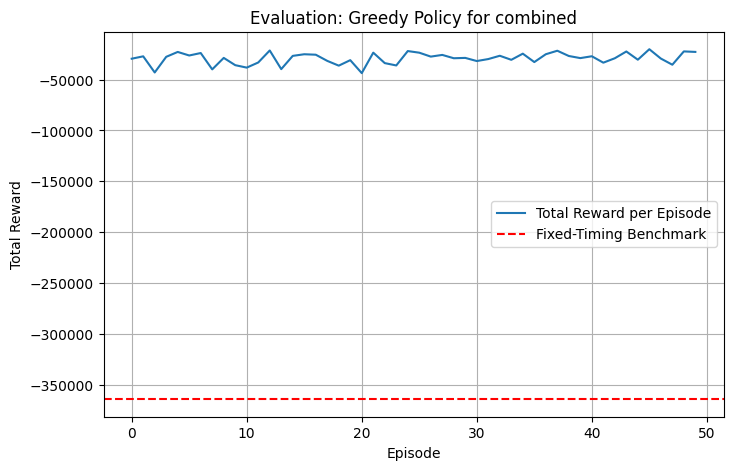

Evaluation results saved in JSON format.


In [ ]:
import matplotlib.pyplot as plt

# Evaluation of trained Q-Learning policy (Greedy Policy with epsilon = 0)
evaluation_episodes = 50  # Number of evaluation episodes
evaluation_results = {reward_fn: {"total_rewards": [], "metrics": []} for reward_fn in reward_functions}

for reward_fn in reward_functions:
    print(f"Evaluating greedy policy for reward function: {reward_fn}")

    # Initialize the SUMO environment
    env = SumoSingleIntersectionEnv(
        net_file="single-intersection.net.xml",
        route_file="single-intersection-horizontal.rou.xml",
        use_gui=False,
        max_steps=1000,
        reward_fn=reward_fn,
    )

    # Initialize Q-Learning agent for evaluation
    agent = QLAgent(
        starting_state=(0,),  # Dummy starting state
        state_space=env.observation_space,
        action_space=env.action_space,
        alpha=0,  # Learning disabled
        gamma=0,  # Not used since no learning happens
        exploration_strategy=None  # Disable exploration
    )
    agent.q_table = {eval(k): v for k, v in ql_results[reward_fn]["q_table"].items()}

    # Run evaluation episodes
    for episode in range(evaluation_episodes):
        state, _ = env.reset()
        agent.state = tuple(state)
        terminated = False
        truncated = False
        total_reward = 0

        while not (terminated or truncated):
            # Greedy action selection
            action = agent.greedy_act()
            next_state, reward, terminated, truncated, _ = env.step(action)
            total_reward += reward
            agent.state = tuple(next_state)

        # Collect metrics for evaluation
        avg_waiting_time, throughput = env.get_metrics()
        evaluation_results[reward_fn]["total_rewards"].append(total_reward)
        evaluation_results[reward_fn]["metrics"].append({"avg_waiting_time": avg_waiting_time, "throughput": throughput})

    env.close()

    # Calculate and print average evaluation results
    avg_reward = sum(evaluation_results[reward_fn]["total_rewards"]) / evaluation_episodes
    avg_waiting_time = sum([m["avg_waiting_time"] for m in evaluation_results[reward_fn]["metrics"]]) / evaluation_episodes
    avg_throughput = sum([m["throughput"] for m in evaluation_results[reward_fn]["metrics"]]) / evaluation_episodes

    print(f"Evaluation Results for {reward_fn}:")
    print(f"Average Reward: {avg_reward:.2f}")
    print(f"Average Waiting Time: {avg_waiting_time:.2f}")
    print(f"Average Throughput: {avg_throughput:.2f}")
    print()

    # Plot total rewards for evaluation
    plt.figure(figsize=(8, 5))
    plt.plot(evaluation_results[reward_fn]["total_rewards"], label="Total Reward per Episode")
    plt.axhline(y=fixed_timing_results[reward_fn], color="red", linestyle="--", label="Fixed-Timing Benchmark")
    plt.title(f"Evaluation: Greedy Policy for {reward_fn}")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.legend()
    plt.grid(True)
    plt.show()

# Save evaluation results to JSON
with open("qlearning_evaluation_results.json", "w") as f:
    json.dump(evaluation_results, f, indent=4)

print("Evaluation results saved in JSON format.")

## 3.2 SARSA

In [ ]:
class SARSAAgent:
    """SARSA Agent class."""

    def __init__(self, starting_state, state_space, action_space, alpha=0.5, gamma=0.95, exploration_strategy=EpsilonGreedy(), decay_rate=0.95):
        self.state = starting_state
        self.state_space = state_space
        self.action_space = action_space
        self.decay_rate = decay_rate
        self.action = None
        self.alpha = alpha
        self.gamma = gamma
        self.q_table = {self.state: [0 for _ in range(action_space.n)]}
        self.exploration = exploration_strategy
        self.acc_reward = 0

    def act(self):
        """Select an action based on the exploration strategy."""
        self.action = self.exploration.choose(self.q_table, self.state, self.action_space)
        return self.action

    def learn(self, next_state, reward, next_action, done=False):
        """Update Q-value using the SARSA update rule."""
        if next_state not in self.q_table:
            self.q_table[next_state] = [0 for _ in range(self.action_space.n)]
        s, a, s1, a1 = self.state, self.action, next_state, next_action
        self.q_table[s][a] += self.alpha * (reward + self.gamma * self.q_table[s1][a1] - self.q_table[s][a])
        self.state = s1
        self.acc_reward += reward

    def decay_learning_rate(self, min_alpha=0.01, decay_rate=None):
        """Decay learning rate dynamically."""
        if decay_rate is None:
            decay_rate = self.decay_rate
        self.alpha = max(min_alpha, self.alpha * decay_rate)

    def greedy_act(self):
        """Select the action with the highest Q-value for the current state."""
        if self.state in self.q_table:
            return self.q_table[self.state].index(max(self.q_table[self.state]))
        else:
            return random.choice(range(self.action_space.n))

    def q_table_to_dict(self):
        """Convert Q-table to a JSON-compatible dictionary."""
        return {str(k): v for k, v in self.q_table.items()}


    def q_table_from_dict(self, q_table_dict):
        """Reconstruct Q-table from a JSON-compatible dictionary."""
        self.q_table = {eval(k): v for k, v in q_table_dict.items()}

#### Random Search for SARSA Optimal Hyperparameters

In [ ]:
import random
import matplotlib.pyplot as plt
import pickle

# Define hyperparameter search space for SARSA
sarsa_hyperparameter_space = {
    "alpha": [0.4, 0.5, 0.6],  # Learning rate
    "gamma": [0.6, 0.7, 0.8],  # Discount factor
    "epsilon": [0.9, 0.95, 1.0],  # Initial exploration rate
    "min_epsilon": [0.01, 0.02, 0.03],  # Minimum epsilon
    "epsilon_decay": [0.95, 0.99, 0.995],  # Exploration decay rate
    "decay_rate": [0.95, 0.99, 0.995],  # Learning rate decay
    "min_alpha": [0.045, 0.05, 0.055],  # Minimum alpha
}

# Number of random search trials per reward function
n_trials = 10
reward_functions = ["diff-waiting-time", "queue", "pressure", "combined"]

# Results dictionary to track the best performance
sarsa_random_search_results = {
    reward_fn: {
        "best_hyperparams": None,
        "best_avg_reward": -float("inf"),
        "best_avg_waiting_time": float("inf"),
        "best_throughput": 0,
    }
    for reward_fn in reward_functions
}

def sample_sarsa_hyperparameters(space):
    """Sample SARSA hyperparameters randomly."""
    return {key: random.choice(values) for key, values in space.items()}

def evaluate_sarsa_hyperparameters(reward_fn, hyperparams, n_episodes=150):
    """Train SARSA and evaluate its performance for given hyperparameters."""
    env = SumoSingleIntersectionEnv(
        net_file="single-intersection.net.xml",
        route_file="single-intersection-horizontal.rou.xml",
        use_gui=False,
        max_steps=1000,
        reward_fn=reward_fn,
    )
    try:
        state, _ = env.reset()
        agent = SARSAAgent(
            starting_state=tuple(state),
            state_space=env.observation_space,
            action_space=env.action_space,
            alpha=hyperparams["alpha"],
            gamma=hyperparams["gamma"],
            exploration_strategy=EpsilonGreedy(
                initial_epsilon=hyperparams["epsilon"],
                min_epsilon=hyperparams["min_epsilon"],
                decay=hyperparams["epsilon_decay"],
            ),
            decay_rate=hyperparams["decay_rate"],

        )
        rewards = []
        avg_waiting_times = []
        throughputs = []

        for _ in range(n_episodes):
            state, _ = env.reset()
            action = agent.act()
            done = False
            total_reward = 0

            while not done:
                next_state, reward, done, _, _ = env.step(action)
                next_action = agent.act()
                agent.learn(next_state=tuple(next_state), reward=reward, next_action=next_action, done=done)
                total_reward += reward
                action = next_action

            # Decay learning rate
            agent.decay_learning_rate()

            # Collect metrics after the episode
            avg_waiting_time, throughput = env.get_metrics()
            rewards.append(total_reward)
            avg_waiting_times.append(avg_waiting_time)
            throughputs.append(throughput)

        # Aggregate results
        avg_reward = sum(rewards) / len(rewards)
        avg_waiting_time = sum(avg_waiting_times) / len(avg_waiting_times)
        avg_throughput = sum(throughputs) / len(throughputs)

        return avg_reward, avg_waiting_time, avg_throughput
    finally:
        env.close()

# Perform SARSA random search
for reward_fn in reward_functions:
    print(f"Random search for SARSA with reward function: {reward_fn}")
    for trial in range(n_trials):
        hyperparams = sample_sarsa_hyperparameters(sarsa_hyperparameter_space)
        avg_reward, avg_waiting_time, avg_throughput = evaluate_sarsa_hyperparameters(reward_fn, hyperparams)

        print(
            f"Trial {trial+1}/{n_trials}: {hyperparams} -> "
            f"Avg Reward: {avg_reward:.2f}, Avg Waiting Time: {avg_waiting_time:.2f}, Throughput: {avg_throughput:.2f}"
        )

        # Update best hyperparameters based on average reward
        if avg_reward > sarsa_random_search_results[reward_fn]["best_avg_reward"]:
            sarsa_random_search_results[reward_fn]["best_avg_reward"] = avg_reward
            sarsa_random_search_results[reward_fn]["best_hyperparams"] = hyperparams
            sarsa_random_search_results[reward_fn]["best_avg_waiting_time"] = avg_waiting_time
            sarsa_random_search_results[reward_fn]["best_throughput"] = avg_throughput

# Display final SARSA results
for reward_fn, result in sarsa_random_search_results.items():
    print(f"Reward Function: {reward_fn}")
    print(f"Best Hyperparameters: {result['best_hyperparams']}")
    print(f"Best Average Reward: {result['best_avg_reward']:.2f}")
    print(f"Best Avg Waiting Time: {result['best_avg_waiting_time']:.2f}")
    print(f"Best Throughput: {result['best_throughput']:.2f}")

# Save SARSA search results
with open("sarsa_random_search.pkl", "wb") as f:
    pickle.dump(sarsa_random_search_results, f)


Random search for SARSA with reward function: diff-waiting-time
Trial 1/10: {'alpha': 0.6, 'gamma': 0.7, 'epsilon': 0.9, 'min_epsilon': 0.01, 'epsilon_decay': 0.95, 'decay_rate': 0.99, 'min_alpha': 0.055} -> Avg Reward: -122034.31, Avg Waiting Time: 10.17, Throughput: 76.41
Trial 2/10: {'alpha': 0.6, 'gamma': 0.6, 'epsilon': 1.0, 'min_epsilon': 0.01, 'epsilon_decay': 0.995, 'decay_rate': 0.995, 'min_alpha': 0.05} -> Avg Reward: -106539.93, Avg Waiting Time: 8.94, Throughput: 74.97
Trial 3/10: {'alpha': 0.4, 'gamma': 0.6, 'epsilon': 0.95, 'min_epsilon': 0.01, 'epsilon_decay': 0.99, 'decay_rate': 0.995, 'min_alpha': 0.045} -> Avg Reward: -116146.75, Avg Waiting Time: 10.13, Throughput: 75.36
Trial 4/10: {'alpha': 0.4, 'gamma': 0.7, 'epsilon': 1.0, 'min_epsilon': 0.02, 'epsilon_decay': 0.995, 'decay_rate': 0.995, 'min_alpha': 0.055} -> Avg Reward: -106384.75, Avg Waiting Time: 8.94, Throughput: 75.11
Trial 5/10: {'alpha': 0.6, 'gamma': 0.6, 'epsilon': 0.95, 'min_epsilon': 0.03, 'epsilon_d

### SARSA Training

Training SARSA with reward function: diff-waiting-time
Episode 50: Avg Reward (Last 50 Episodes) = -109986.90
Episode 100: Avg Reward (Last 50 Episodes) = -101602.02
Learning plateau detected at Episode 144. Stopping early.
Final Average Reward for SARSA (diff-waiting-time): -104968.11
Overall Improvement for SARSA (diff-waiting-time): 94.07%


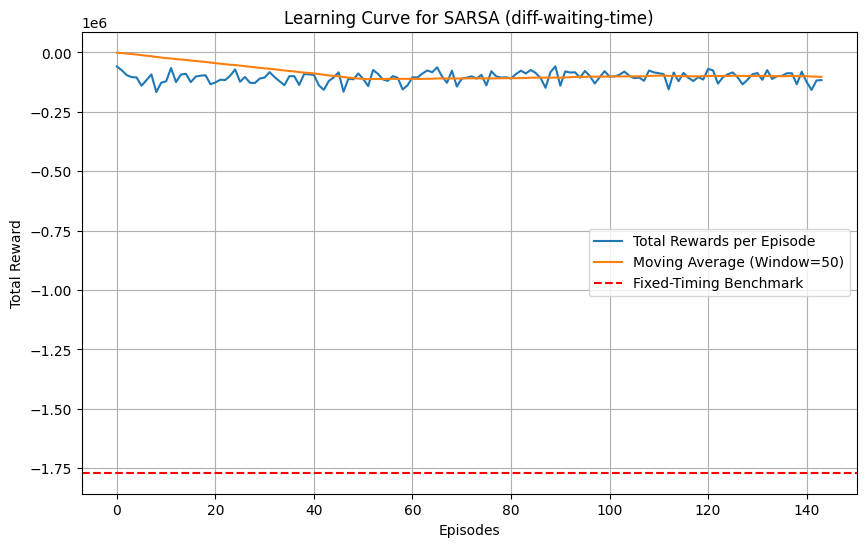

Training SARSA with reward function: queue
Episode 50: Avg Reward (Last 50 Episodes) = -6583.66
Episode 100: Avg Reward (Last 50 Episodes) = -6756.78
Learning plateau detected at Episode 100. Stopping early.
Final Average Reward for SARSA (queue): -6670.22
Overall Improvement for SARSA (queue): 51.06%


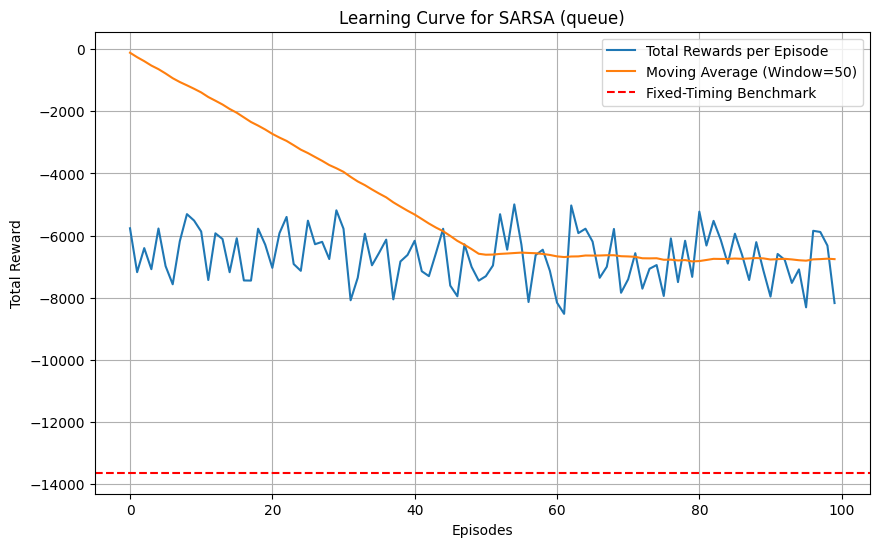

Training SARSA with reward function: pressure
Episode 50: Avg Reward (Last 50 Episodes) = -10297.44
Episode 100: Avg Reward (Last 50 Episodes) = -10022.88
Learning plateau detected at Episode 106. Stopping early.
Final Average Reward for SARSA (pressure): -10184.75
Overall Improvement for SARSA (pressure): 28.43%


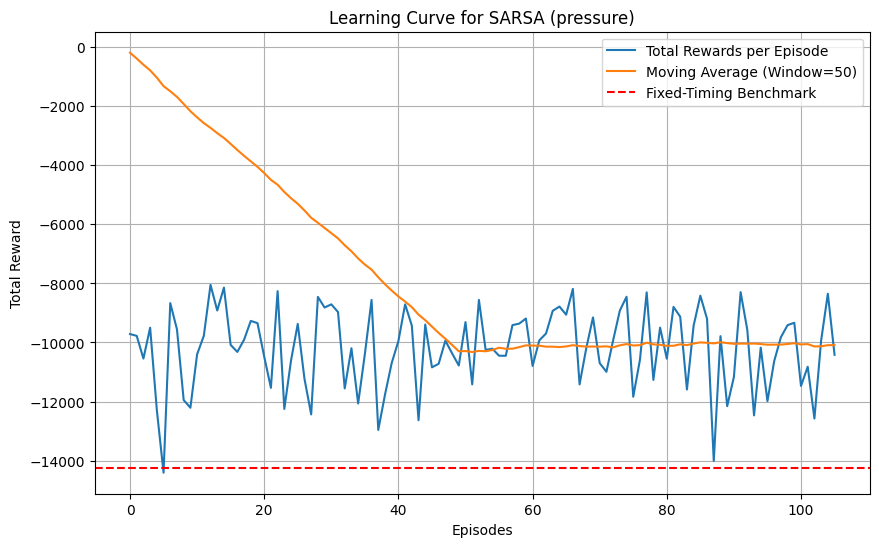

Training SARSA with reward function: combined
Episode 50: Avg Reward (Last 50 Episodes) = -28681.83
Episode 100: Avg Reward (Last 50 Episodes) = -29771.68
Learning plateau detected at Episode 100. Stopping early.
Final Average Reward for SARSA (combined): -29226.76
Overall Improvement for SARSA (combined): 91.98%


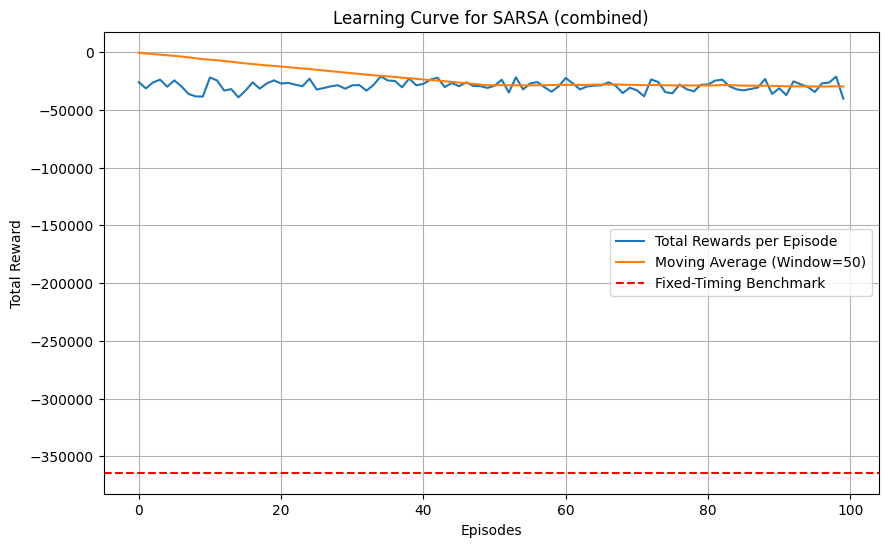

SARSA results saved as JSON.


In [ ]:
# Define SARSA reward-specific hyperparameters
sarsa_reward_functions = {
    "diff-waiting-time": {"alpha": 0.4, "gamma": 0.7, "epsilon": 1.0, "min_epsilon": 0.02, "epsilon_decay": 0.95, "decay_rate": 0.99, "min_alpha": 0.055},
    "queue": {"alpha": 0.5, "gamma": 0.6, "epsilon": 1.0, "min_epsilon": 0.01, "epsilon_decay": 0.99, "decay_rate": 0.95, "min_alpha": 0.055},
    "pressure": {"alpha": 0.6, "gamma": 0.6, "epsilon": 1.0, "min_epsilon": 0.01, "epsilon_decay": 0.95, "decay_rate": 0.95, "min_alpha": 0.055},
    "combined": {"alpha": 0.4, "gamma": 0.8, "epsilon": 1.0, "min_epsilon": 0.01, "epsilon_decay": 0.99, "decay_rate": 0.95, "min_alpha": 0.045},
}

window_size = 50
plateau_threshold = 1.0

# Initialize SARSA results structure
sarsa_results = {reward_fn: {"rewards": [], "metrics": []} for reward_fn in sarsa_reward_functions}

for reward_fn, hyperparams in sarsa_reward_functions.items():
    print(f"Training SARSA with reward function: {reward_fn}")

    env = SumoSingleIntersectionEnv(
        net_file="single-intersection.net.xml",
        route_file="single-intersection-horizontal.rou.xml",
        use_gui=False,
        max_steps=1000,
        reward_fn=reward_fn,
    )

    initial_state, _ = env.reset()
    agent = SARSAAgent(
        starting_state=tuple(initial_state),
        state_space=env.observation_space,
        action_space=env.action_space,
        alpha=hyperparams["alpha"],
        gamma=hyperparams["gamma"],
        exploration_strategy=EpsilonGreedy(
            initial_epsilon=hyperparams["epsilon"],
            min_epsilon=hyperparams["min_epsilon"],
            decay=hyperparams["epsilon_decay"],
        ),
        decay_rate=hyperparams["decay_rate"],
    )

    total_rewards = []
    moving_avg_rewards = deque(maxlen=window_size)

    for episode in range(500):
        state, _ = env.reset()
        action = agent.act()
        terminated = False
        truncated = False
        total_reward = 0

        while not (terminated or truncated):
            next_state, reward, terminated, truncated, _ = env.step(action)
            next_action = agent.act()
            agent.learn(next_state=tuple(next_state), reward=reward, next_action=next_action, done=terminated)
            total_reward += reward
            action = next_action

        total_rewards.append(total_reward)
        moving_avg_rewards.append(total_reward)

        # Collect metrics
        avg_waiting_time, throughput = env.get_metrics()
        if "metrics" not in sarsa_results[reward_fn]:
            sarsa_results[reward_fn]["metrics"] = []
        sarsa_results[reward_fn]["metrics"].append({"avg_waiting_time": avg_waiting_time, "throughput": throughput})

        # Apply learning rate decay
        agent.decay_learning_rate(min_alpha=hyperparams["min_alpha"])

        # Log progress every 50 episodes
        if (episode + 1) % 50 == 0:
            avg_reward = sum(total_rewards[-50:]) / 50
            print(f"Episode {episode + 1}: Avg Reward (Last 50 Episodes) = {avg_reward:.2f}")

        # Check for plateau
        if len(moving_avg_rewards) == window_size:
            avg_last_window = sum(moving_avg_rewards) / window_size
            avg_previous_window = sum(total_rewards[-2 * window_size:-window_size]) / window_size if len(total_rewards) >= 2 * window_size else -float('inf')
            improvement = (avg_last_window - avg_previous_window) / abs(avg_previous_window) * 100 if avg_previous_window != 0 else 0
            if improvement < plateau_threshold:
                print(f"Learning plateau detected at Episode {episode + 1}. Stopping early.")
                break

    # Calculate overall results
    overall_avg_reward = sum(total_rewards) / len(total_rewards)
    overall_improvement = ((overall_avg_reward - fixed_timing_results[reward_fn]) / abs(fixed_timing_results[reward_fn])) * 100
    avg_waiting_time = sum(m["avg_waiting_time"] for m in sarsa_results[reward_fn]["metrics"]) / len(sarsa_results[reward_fn]["metrics"])
    avg_throughput = sum(m["throughput"] for m in sarsa_results[reward_fn]["metrics"]) / len(sarsa_results[reward_fn]["metrics"])

    # Save results
    sarsa_results[reward_fn]["overall_avg_reward"] = overall_avg_reward
    sarsa_results[reward_fn]["overall_improvement"] = overall_improvement
    sarsa_results[reward_fn]["avg_waiting_time"] = avg_waiting_time
    sarsa_results[reward_fn]["avg_throughput"] = avg_throughput
    sarsa_results[reward_fn]["rewards"] = total_rewards
    sarsa_results[reward_fn]["q_table"] = agent.q_table_to_dict()

    print(f"Final Average Reward for SARSA ({reward_fn}): {overall_avg_reward:.2f}")
    print(f"Overall Improvement for SARSA ({reward_fn}): {overall_improvement:.2f}%")
    env.close()

    # Plot results
    plt.figure(figsize=(10, 6))
    plt.plot(total_rewards, label="Total Rewards per Episode")
    plt.plot(
        [sum(total_rewards[max(0, i - window_size):i]) / window_size for i in range(1, len(total_rewards) + 1)],
        label=f"Moving Average (Window={window_size})",
    )
    plt.axhline(y=fixed_timing_results[reward_fn], color="red", linestyle="--", label="Fixed-Timing Benchmark")
    plt.title(f"Learning Curve for SARSA ({reward_fn})")
    plt.xlabel("Episodes")
    plt.ylabel("Total Reward")
    plt.legend()
    plt.grid(True)
    plt.show()
    print("\n")

# Save results to JSON
with open("sarsa_results.json", "w") as f:
    json.dump(sarsa_results, f, indent=4)
print("SARSA results saved as JSON.")


Once the training loop finishes, evaluate the agent by setting epsilon = 0 (no exploration). exploits the learned Q-values (optimal actions) without exploration. This tests how well the agent performs using its final Q-table.

Evaluating greedy policy for SARSA with reward function: diff-waiting-time
Evaluation Results for diff-waiting-time:
Average Reward: -104402.00
Average Waiting Time: 10.09
Average Throughput: 76.50



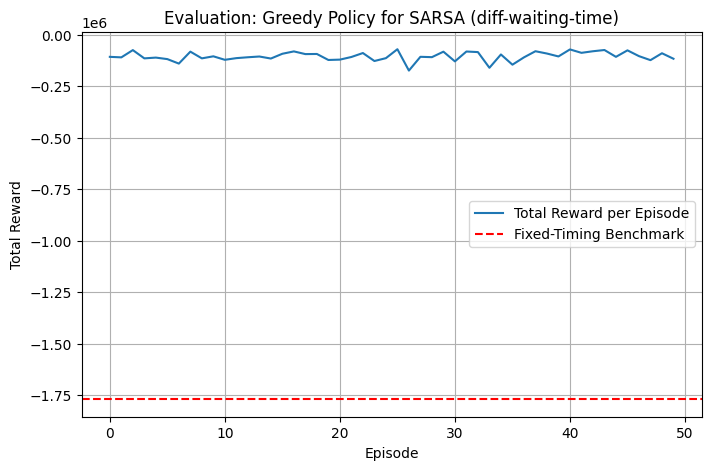


Evaluating greedy policy for SARSA with reward function: queue
Evaluation Results for queue:
Average Reward: -6408.62
Average Waiting Time: 8.62
Average Throughput: 72.36



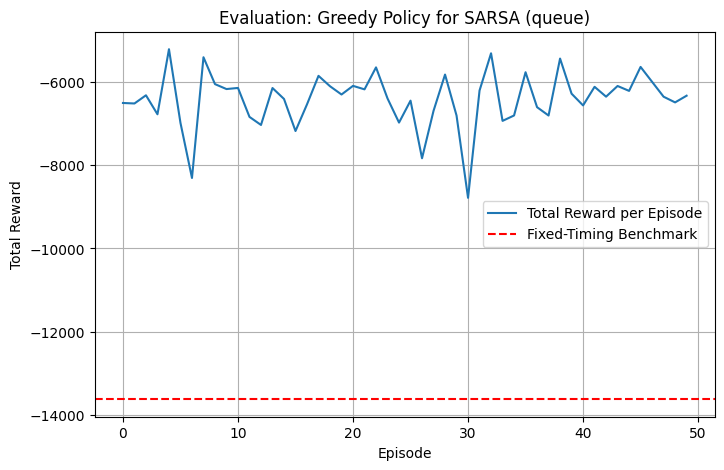


Evaluating greedy policy for SARSA with reward function: pressure
Evaluation Results for pressure:
Average Reward: -10145.56
Average Waiting Time: 7.76
Average Throughput: 75.28



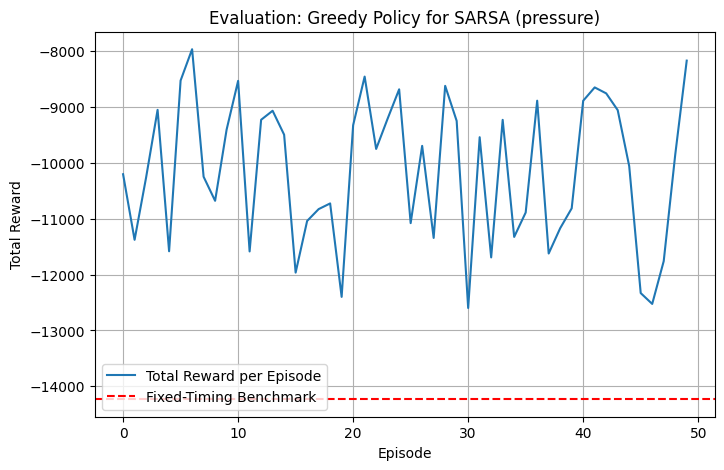


Evaluating greedy policy for SARSA with reward function: combined
Evaluation Results for combined:
Average Reward: -29094.60
Average Waiting Time: 6.79
Average Throughput: 76.66



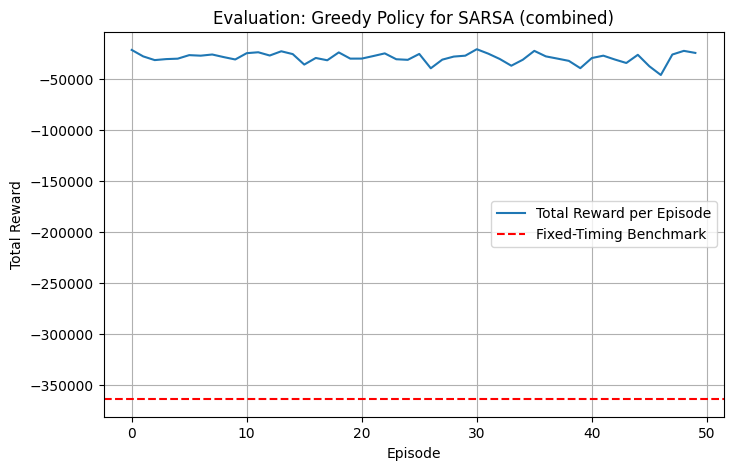


SARSA evaluation results saved as JSON.


In [ ]:
# Evaluation of trained SARSA policy
evaluation_episodes = 50  # Number of evaluation episodes
evaluation_results = {reward_fn: {"total_rewards": [], "metrics": []} for reward_fn in sarsa_reward_functions}

for reward_fn in sarsa_reward_functions:
    print(f"Evaluating greedy policy for SARSA with reward function: {reward_fn}")

    env = SumoSingleIntersectionEnv(
        net_file="single-intersection.net.xml",
        route_file="single-intersection-horizontal.rou.xml",
        use_gui=False,
        max_steps=1000,
        reward_fn=reward_fn,
    )

    # Initialize the SARSA agent with dummy starting state and no learning
    agent = SARSAAgent(
        starting_state=(0,),  # Dummy state; will reset properly
        state_space=env.observation_space,
        action_space=env.action_space,
        alpha=0,  # Disable learning
        gamma=0,  # No learning updates
        exploration_strategy=None  # No exploration
    )

    # Load trained Q-table
    agent.q_table_from_dict(sarsa_results[reward_fn]["q_table"])

    for episode in range(evaluation_episodes):
        state, _ = env.reset()
        agent.state = tuple(state)
        terminated = False
        truncated = False
        total_reward = 0

        while not (terminated or truncated):
            # Act greedily: choose action with max Q-value
            action = agent.greedy_act()
            next_state, reward, terminated, truncated, _ = env.step(action)
            total_reward += reward
            agent.state = tuple(next_state)

        # Get metrics for evaluation
        avg_waiting_time, throughput = env.get_metrics()
        evaluation_results[reward_fn]["total_rewards"].append(total_reward)
        evaluation_results[reward_fn]["metrics"].append({"avg_waiting_time": avg_waiting_time, "throughput": throughput})

    env.close()

    # Calculate and print evaluation results
    avg_reward = sum(evaluation_results[reward_fn]["total_rewards"]) / evaluation_episodes
    avg_waiting_time = sum([m["avg_waiting_time"] for m in evaluation_results[reward_fn]["metrics"]]) / evaluation_episodes
    avg_throughput = sum([m["throughput"] for m in evaluation_results[reward_fn]["metrics"]]) / evaluation_episodes

    print(f"Evaluation Results for {reward_fn}:")
    print(f"Average Reward: {avg_reward:.2f}")
    print(f"Average Waiting Time: {avg_waiting_time:.2f}")
    print(f"Average Throughput: {avg_throughput:.2f}")
    print()

    # Plot rewards
    plt.figure(figsize=(8, 5))
    plt.plot(evaluation_results[reward_fn]["total_rewards"], label="Total Reward per Episode")
    plt.axhline(y=fixed_timing_results[reward_fn], color="red", linestyle="--", label="Fixed-Timing Benchmark")
    plt.title(f"Evaluation: Greedy Policy for SARSA ({reward_fn})")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.legend()
    plt.grid(True)
    plt.show()
    print()

# Save evaluation results to JSON
with open("sarsa_evaluation_results.json", "w") as f:
    json.dump(evaluation_results, f, indent=4)
print("SARSA evaluation results saved as JSON.")


## 3.3 Deep Q-Network

#### Random Search DQN

In [ ]:

# Define hyperparameter search space for DQN
dqn_hyperparameter_space = {
    "learning_rate": [0.0001, 0.0005,0.001],  # Learning rate
    #"gamma": [0.9, 0.95, 0.99],  # Discount factor
    "buffer_size": [10000, 30000, 50000],  # Replay buffer size
    "exploration_fraction": [0.05, 0.1, 0.15],  # Exploration fraction
    "exploration_initial_eps": [0.05, 0.1],  # Initial epsilon
    "exploration_final_eps": [0.005, 0.01, 0.02],  # Final epsilon
}

# Number of random search trials per reward function
n_trials = 10
reward_functions = ["diff-waiting-time", "queue", "pressure", "combined"]


# Results dictionary to track the best performance
dqn_random_search_results = {
    reward_fn: {
        "best_hyperparams": None,
        "best_avg_reward": -float("inf"),
        "best_avg_waiting_time": float("inf"),
        "best_throughput": 0,
    }
    for reward_fn in reward_functions
}

def sample_dqn_hyperparameters(space):
    """Randomly sample hyperparameters from the DQN search space."""
    return {key: random.choice(values) for key, values in space.items()}

def evaluate_dqn_hyperparameters(reward_fn, hyperparams, n_episodes=50, timesteps=25000):
    """Train and evaluate DQN with given hyperparameters."""
    env = SumoSingleIntersectionEnv(
        net_file="single-intersection.net.xml",
        route_file="single-intersection-horizontal.rou.xml",
        use_gui=False,
        max_steps=1000,
        reward_fn=reward_fn,
    )
    try:
        # Initialize DQN model
        model = DQN(
            policy="MlpPolicy",
            env=env,
            learning_rate=hyperparams["learning_rate"],
            learning_starts=0,
            train_freq=1,
            target_update_interval=500,
            # gamma=hyperparams["gamma"],
            buffer_size=hyperparams["buffer_size"],
            exploration_fraction=hyperparams["exploration_fraction"],
            exploration_initial_eps=hyperparams["exploration_initial_eps"],
            exploration_final_eps=hyperparams["exploration_final_eps"],
            verbose=0,
        )

        # Train the DQN model
        model.learn(total_timesteps=timesteps)

        # Evaluate the trained model
        rewards = []
        avg_waiting_times = []
        throughputs = []

        for _ in range(n_episodes):
            state, _ = env.reset()
            done = False
            total_reward = 0

            while not done:
                action, _ = model.predict(state)
                state, reward, terminated, truncated, _ = env.step(action)
                done = terminated or truncated


                reward_tensor = th.tensor(reward, dtype=th.float32)
                total_reward = total_reward + reward_tensor

            # Collect metrics after the episode
            avg_waiting_time, throughput = env.get_metrics()
            rewards.append(total_reward.item())
            avg_waiting_times.append(avg_waiting_time)
            throughputs.append(throughput)

        # Aggregate results
        avg_reward = sum(rewards) / len(rewards)
        avg_waiting_time = sum(avg_waiting_times) / len(avg_waiting_times)
        avg_throughput = sum(throughputs) / len(throughputs)

        return avg_reward, avg_waiting_time, avg_throughput
    finally:
        env.close()

# Perform DQN random search
for reward_fn in reward_functions:
    print(f"Random search for DQN with reward function: {reward_fn}")
    for trial in range(n_trials):
        hyperparams = sample_dqn_hyperparameters(dqn_hyperparameter_space)
        avg_reward, avg_waiting_time, avg_throughput = evaluate_dqn_hyperparameters(reward_fn, hyperparams)

        print(
            f"Trial {trial+1}/{n_trials}: {hyperparams} -> "
            f"Avg Reward: {avg_reward:.2f}, Avg Waiting Time: {avg_waiting_time:.2f}, Throughput: {avg_throughput:.2f}"
        )

        # Update best hyperparameters based on average reward
        if avg_reward > dqn_random_search_results[reward_fn]["best_avg_reward"]:
            dqn_random_search_results[reward_fn]["best_avg_reward"] = avg_reward
            dqn_random_search_results[reward_fn]["best_hyperparams"] = hyperparams
            dqn_random_search_results[reward_fn]["best_avg_waiting_time"] = avg_waiting_time
            dqn_random_search_results[reward_fn]["best_throughput"] = avg_throughput

# Display final DQN results
for reward_fn, result in dqn_random_search_results.items():
    print(f"Reward Function: {reward_fn}")
    print(f"Best Hyperparameters: {result['best_hyperparams']}")
    print(f"Best Average Reward: {result['best_avg_reward']:.2f}")
    print(f"Best Avg Waiting Time: {result['best_avg_waiting_time']:.2f}")
    print(f"Best Throughput: {result['best_throughput']:.2f}")




Random search for DQN with reward function: combined


KeyboardInterrupt: 

### Training DQN

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Training DQN with reward function: diff-waiting-time
DQN Episode 50: Avg Reward (Last 50 Episodes) = -2280169.00, Improvement = -28.90%
DQN Episode 100: Avg Reward (Last 50 Episodes) = -2280169.00, Improvement = -28.90%
Learning plateau detected at Episode 100. Stopping early.
Final Average Reward for DQN (diff-waiting-time): -2280169.00
Overall Improvement for DQN (diff-waiting-time): -28.90%


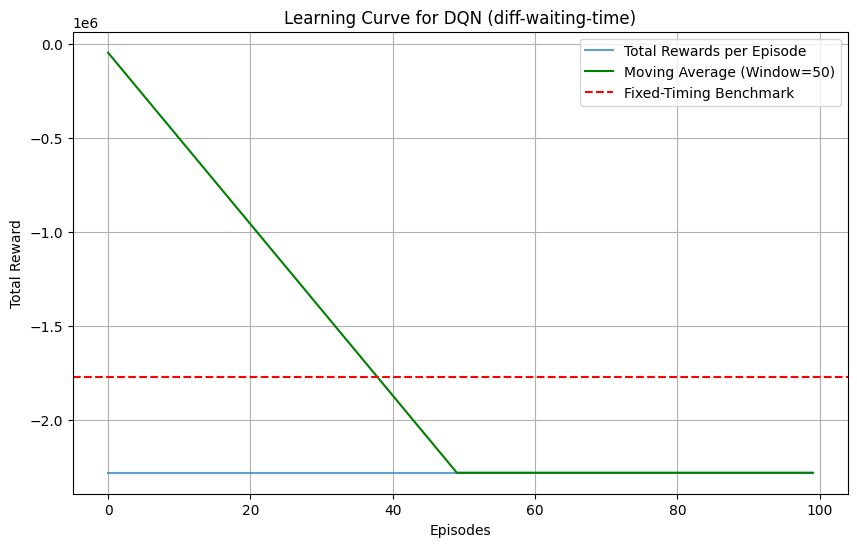


Training DQN with reward function: queue
DQN Episode 50: Avg Reward (Last 50 Episodes) = -10082.00, Improvement = 26.03%
DQN Episode 100: Avg Reward (Last 50 Episodes) = -10082.00, Improvement = 26.03%
Learning plateau detected at Episode 100. Stopping early.
Final Average Reward for DQN (queue): -10082.00
Overall Improvement for DQN (queue): 26.03%


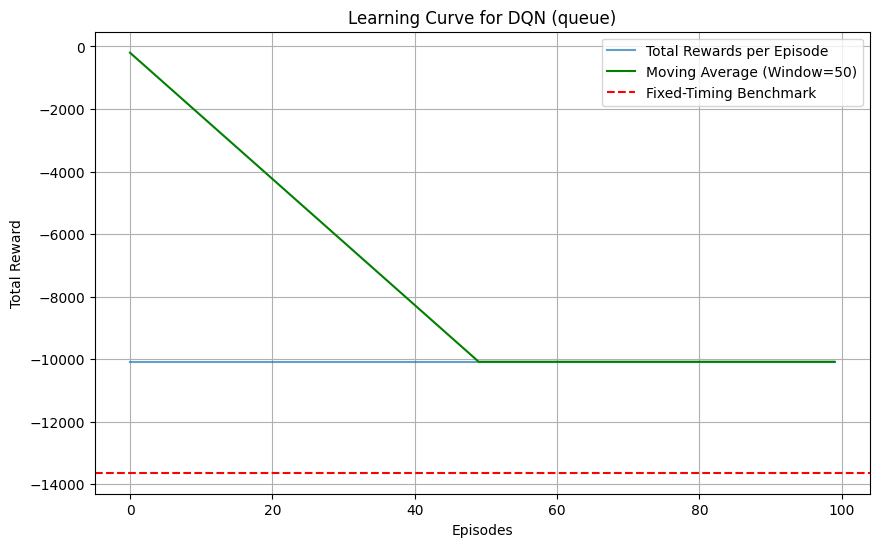


Training DQN with reward function: pressure
DQN Episode 50: Avg Reward (Last 50 Episodes) = -7853.00, Improvement = 44.82%
DQN Episode 100: Avg Reward (Last 50 Episodes) = -7853.00, Improvement = 44.82%
Learning plateau detected at Episode 100. Stopping early.
Final Average Reward for DQN (pressure): -7853.00
Overall Improvement for DQN (pressure): 44.82%


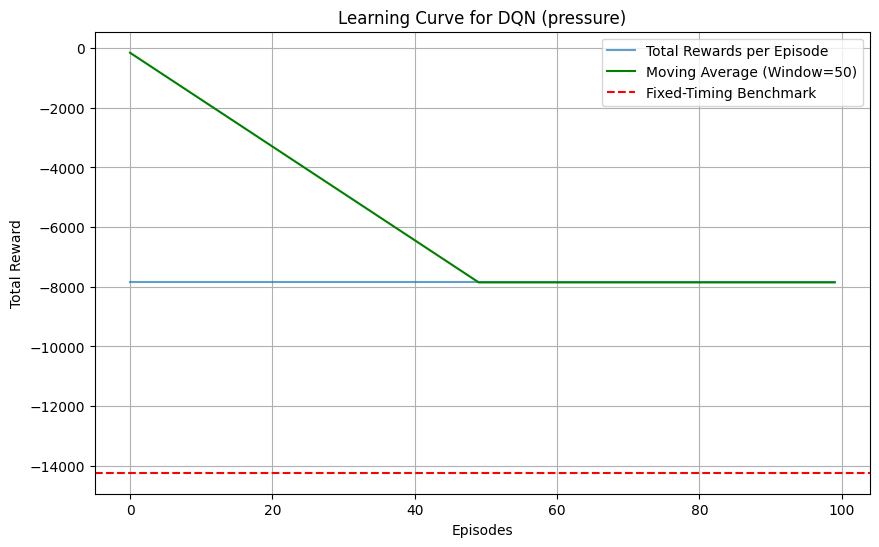


Training DQN with reward function: combined
DQN Episode 50: Avg Reward (Last 50 Episodes) = -485443.22, Improvement = -33.27%
DQN Episode 100: Avg Reward (Last 50 Episodes) = -485443.22, Improvement = -33.27%
Learning plateau detected at Episode 100. Stopping early.
Final Average Reward for DQN (combined): -485443.22
Overall Improvement for DQN (combined): -33.27%


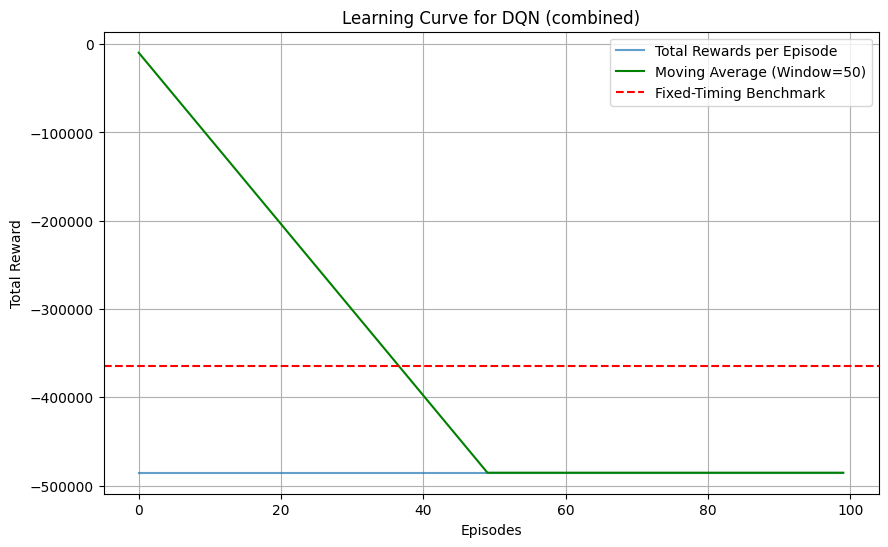


DQN results saved in JSON format.


In [ ]:
# Define DQN reward-specific hyperparameters
dqn_reward_functions = {
    "diff-waiting-time": {"learning_rate": 0.0001, "buffer_size": 30000, "exploration_fraction": 0.15, "exploration_initial_eps": 0.1, "exploration_final_eps": 0.02},
    "queue": {"learning_rate": 0.001, "buffer_size": 50000, "exploration_fraction": 0.1, "exploration_initial_eps": 0.1, "exploration_final_eps": 0.01},
    "pressure": {"learning_rate": 0.001, "buffer_size": 30000, "exploration_fraction": 0.05, "exploration_initial_eps": 0.05, "exploration_final_eps": 0.005},
    "combined": {"learning_rate": 0.0005, "buffer_size": 30000, "exploration_fraction": 0.1, "exploration_initial_eps": 0.05, "exploration_final_eps": 0.02},
}

window_size = 50  # Moving average window
plateau_threshold = 1.0  # Threshold for plateau detection

dqn_results = {reward_fn: {"rewards": [], "metrics": []} for reward_fn in dqn_reward_functions}

for reward_fn, hyperparams in dqn_reward_functions.items():
    print(f"Training DQN with reward function: {reward_fn}")

    env = SumoSingleIntersectionEnv(
        net_file="single-intersection.net.xml",
        route_file="single-intersection-horizontal.rou.xml",
        use_gui=False,
        max_steps=1000,
        reward_fn=reward_fn,
    )

    model = DQN(
        policy="MlpPolicy",
        env=env,
        learning_rate=hyperparams["learning_rate"],
        buffer_size=hyperparams["buffer_size"],
        learning_starts=0,
        train_freq=1,  # Training happens at every step
        target_update_interval=500,  # Update the target network every 500 steps
        exploration_fraction=hyperparams["exploration_fraction"],
        exploration_initial_eps=hyperparams["exploration_initial_eps"],
        exploration_final_eps=hyperparams["exploration_final_eps"],
        verbose=0,  # Logging output during training (set to 1 for debug info)
    )

    # Train the agent
    model.learn(total_timesteps=100000)

    total_rewards = []
    moving_avg_rewards = deque(maxlen=window_size)

    for episode in range(500):
        state, _ = env.reset()
        terminated = False
        truncated = False
        total_reward = 0

        while not (terminated or truncated):
            action, _ = model.predict(state, deterministic=True)
            state, reward, terminated, truncated, _ = env.step(action)
            total_reward += reward

        # Save metrics for the episode
        total_rewards.append(total_reward)
        moving_avg_rewards.append(total_reward)
        avg_waiting_time, throughput = env.get_metrics()
        dqn_results[reward_fn]["metrics"].append({"avg_waiting_time": avg_waiting_time, "throughput": throughput})

        # Log progress every 50 episodes
        if (episode + 1) % 50 == 0:
            avg_reward = sum(total_rewards[-50:]) / 50
            improvement = ((avg_reward - fixed_timing_results[reward_fn]) / abs(fixed_timing_results[reward_fn])) * 100
            print(f"DQN Episode {episode + 1}: Avg Reward (Last 50 Episodes) = {avg_reward:.2f}, Improvement = {improvement:.2f}%")

        # Check for plateau
        if len(moving_avg_rewards) == window_size:
            avg_last_window = sum(moving_avg_rewards) / window_size
            avg_previous_window = sum(total_rewards[-2 * window_size:-window_size]) / window_size if len(total_rewards) >= 2 * window_size else -float('inf')
            improvement = (avg_last_window - avg_previous_window) / abs(avg_previous_window) * 100 if avg_previous_window != 0 else 0

            if improvement < plateau_threshold:
                print(f"Learning plateau detected at Episode {episode + 1}. Stopping early.")
                break

    # Calculate overall results
    overall_avg_reward = sum(total_rewards) / len(total_rewards)
    overall_improvement = ((overall_avg_reward - fixed_timing_results[reward_fn]) / abs(fixed_timing_results[reward_fn])) * 100
    avg_waiting_time = sum(m["avg_waiting_time"] for m in dqn_results[reward_fn]["metrics"]) / len(dqn_results[reward_fn]["metrics"])
    avg_throughput = sum(m["throughput"] for m in dqn_results[reward_fn]["metrics"]) / len(dqn_results[reward_fn]["metrics"])

    # Save results
    dqn_results[reward_fn]["overall_avg_reward"] = overall_avg_reward
    dqn_results[reward_fn]["overall_improvement"] = overall_improvement
    dqn_results[reward_fn]["avg_waiting_time"] = avg_waiting_time
    dqn_results[reward_fn]["avg_throughput"] = avg_throughput
    dqn_results[reward_fn]["rewards"] = total_rewards

    print(f"Final Average Reward for DQN ({reward_fn}): {overall_avg_reward:.2f}")
    print(f"Overall Improvement for DQN ({reward_fn}): {overall_improvement:.2f}%")
    env.close()

    # Plot results
    plt.figure(figsize=(10, 6))
    plt.plot(total_rewards, label="Total Rewards per Episode", alpha=0.7)
    plt.plot(
        [sum(total_rewards[max(0, i - window_size):i]) / window_size for i in range(1, len(total_rewards) + 1)],
        label=f"Moving Average (Window={window_size})",
        color="green",
    )
    plt.axhline(y=fixed_timing_results[reward_fn], color="red", linestyle="--", label="Fixed-Timing Benchmark")
    plt.title(f"Learning Curve for DQN ({reward_fn})")
    plt.xlabel("Episodes")
    plt.ylabel("Total Reward")
    plt.legend()
    plt.grid(True)
    plt.show()
    print()

# Save DQN results as JSON
with open("dqn_results.json", "w") as f:
    json.dump(dqn_results, f, indent=4)
print("DQN results saved in JSON format.")


# 4. Evaluation

Results loaded successfully.
Reward Function      Algorithm       Avg Reward   Improvement (%) Avg Wait Time   Throughput  
diff-waiting-time    Fixed-Timing    -1768994.00  -               52.78           82.00       
                     Q-Learning      -105477.86   94.04           8.27            74.23       
                     SARSA           -104968.11   94.07           8.05            75.36       
                     DQN             -2280169.00  -28.90          52.93           122.00      
----------------------------------------------------------------------------------------------------
queue                Fixed-Timing    -13629.00    -               52.78           82.00       
                     Q-Learning      -6498.17     52.32           8.73            74.19       
                     SARSA           -6670.22     51.06           11.39           74.63       
                     DQN             -10082.00    26.03           35.19           79.00       
---------------

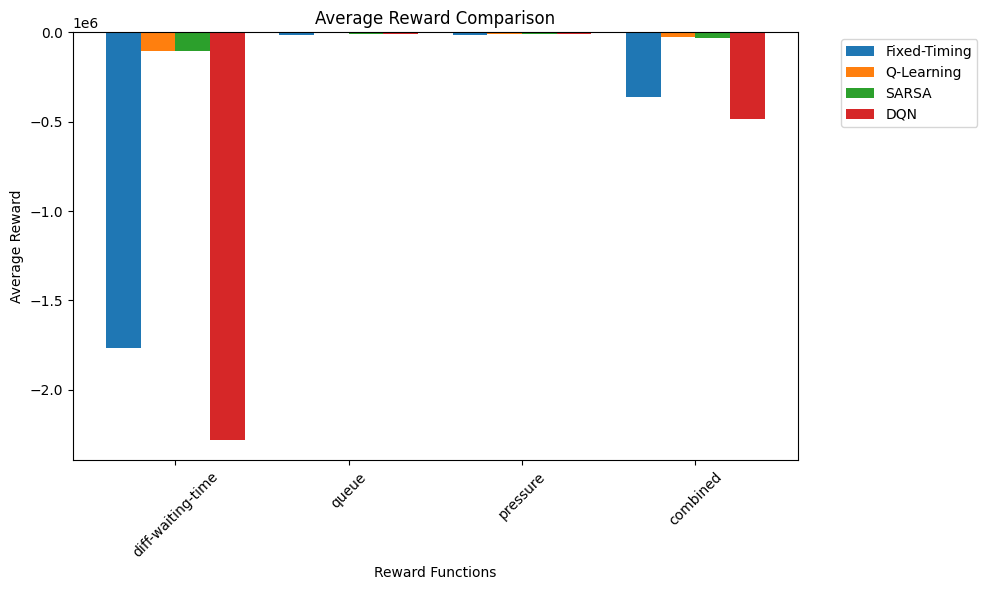

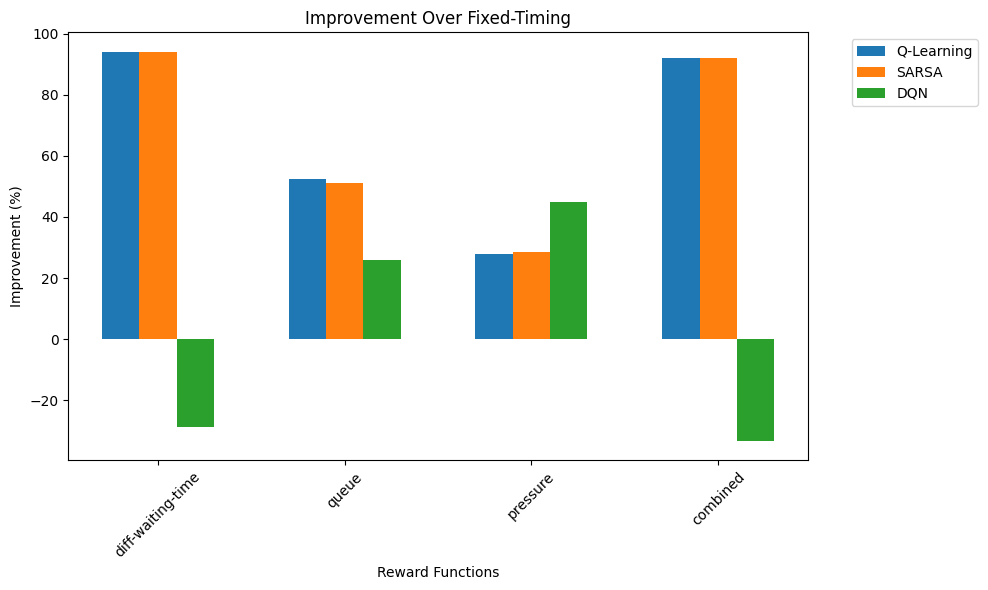

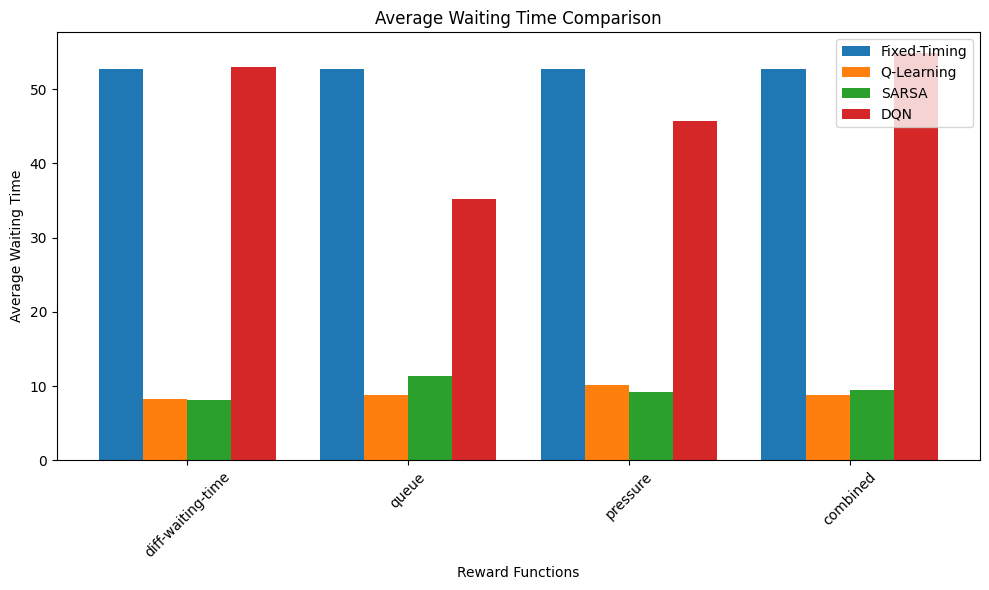

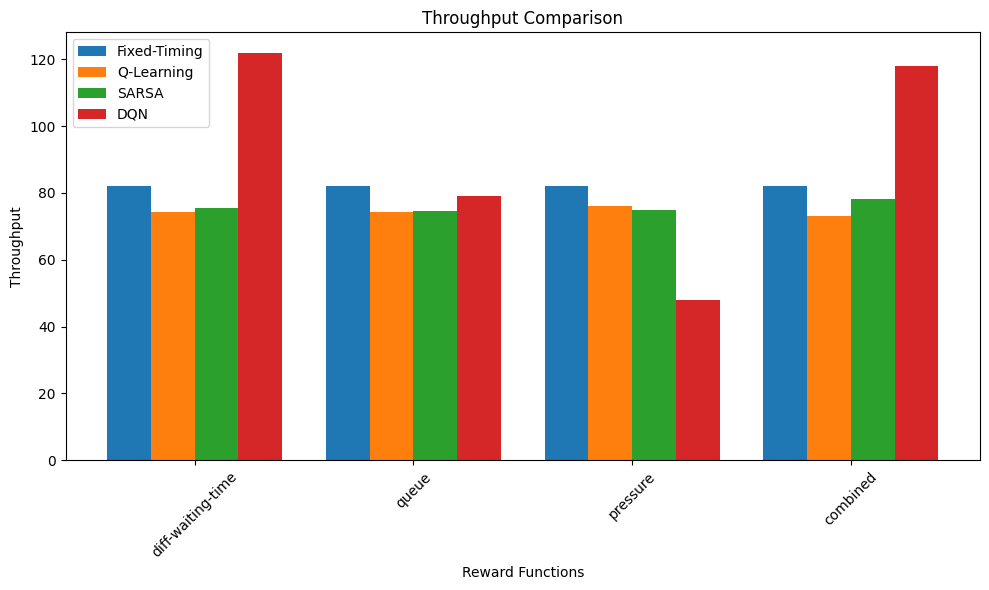


Evaluation and plots completed successfully.


In [ ]:
# Load results
with open("ql_results.json", "r") as f:
    qlearning_results = json.load(f)

with open("sarsa_results.json", "r") as f:
    sarsa_results = json.load(f)

with open("dqn_results.json", "r") as f:
    dqn_results = json.load(f)

with open("fixed_timing_results.json", "r") as f:
    fixed_timing_results = json.load(f)

print("Results loaded successfully.")

# Initialize containers
reward_functions = list(fixed_timing_results.keys())
avg_rewards = {alg: [] for alg in ["Fixed-Timing", "Q-Learning", "SARSA", "DQN"]}
improvements = {"Q-Learning": [], "SARSA": [], "DQN": []}
waiting_times = {alg: [] for alg in ["Fixed-Timing", "Q-Learning", "SARSA", "DQN"]}
throughputs = {alg: [] for alg in ["Fixed-Timing", "Q-Learning", "SARSA", "DQN"]}

print("=" * 100)
print(f"{'Reward Function':<20} {'Algorithm':<15} {'Avg Reward':<12} {'Improvement (%)':<15} {'Avg Wait Time':<15} {'Throughput':<12}")
print("=" * 100)

# Collect and print metrics
for reward_fn in reward_functions:
    fixed_reward = fixed_timing_results[reward_fn]["overall_avg_reward"]
    fixed_avg_waiting = fixed_timing_results[reward_fn]["avg_waiting_time"]
    fixed_throughput = fixed_timing_results[reward_fn]["avg_throughput"]

    q_avg_reward = qlearning_results[reward_fn]["overall_avg_reward"]
    q_improvement = qlearning_results[reward_fn]["overall_improvement"]
    q_avg_waiting = qlearning_results[reward_fn]["avg_waiting_time"]
    q_throughput = qlearning_results[reward_fn]["avg_throughput"]

    s_avg_reward = sarsa_results[reward_fn]["overall_avg_reward"]
    s_improvement = sarsa_results[reward_fn]["overall_improvement"]
    s_avg_waiting = sarsa_results[reward_fn]["avg_waiting_time"]
    s_throughput = sarsa_results[reward_fn]["avg_throughput"]

    d_avg_reward = dqn_results[reward_fn]["overall_avg_reward"]
    d_improvement = dqn_results[reward_fn]["overall_improvement"]
    d_avg_waiting = dqn_results[reward_fn]["avg_waiting_time"]
    d_throughput = dqn_results[reward_fn]["avg_throughput"]

    # Print results
    print(f"{reward_fn:<20} {'Fixed-Timing':<15} {fixed_reward:<12.2f} {'-':<15} {fixed_avg_waiting:<15.2f} {fixed_throughput:<12.2f}")
    print(f"{'':<20} {'Q-Learning':<15} {q_avg_reward:<12.2f} {q_improvement:<15.2f} {q_avg_waiting:<15.2f} {q_throughput:<12.2f}")
    print(f"{'':<20} {'SARSA':<15} {s_avg_reward:<12.2f} {s_improvement:<15.2f} {s_avg_waiting:<15.2f} {s_throughput:<12.2f}")
    print(f"{'':<20} {'DQN':<15} {d_avg_reward:<12.2f} {d_improvement:<15.2f} {d_avg_waiting:<15.2f} {d_throughput:<12.2f}")
    print("-" * 100)

    # Store for plotting
    avg_rewards["Fixed-Timing"].append(fixed_reward)
    avg_rewards["Q-Learning"].append(q_avg_reward)
    avg_rewards["SARSA"].append(s_avg_reward)
    avg_rewards["DQN"].append(d_avg_reward)

    improvements["Q-Learning"].append(q_improvement)
    improvements["SARSA"].append(s_improvement)
    improvements["DQN"].append(d_improvement)

    waiting_times["Fixed-Timing"].append(fixed_avg_waiting)
    waiting_times["Q-Learning"].append(q_avg_waiting)
    waiting_times["SARSA"].append(s_avg_waiting)
    waiting_times["DQN"].append(d_avg_waiting)

    throughputs["Fixed-Timing"].append(fixed_throughput)
    throughputs["Q-Learning"].append(q_throughput)
    throughputs["SARSA"].append(s_throughput)
    throughputs["DQN"].append(d_throughput)

# Define x-axis
x = np.arange(len(reward_functions))
width = 0.2

# Plot 1: Average Rewards Comparison
plt.figure(figsize=(10, 6))
plt.bar(x - 1.5 * width, avg_rewards["Fixed-Timing"], width, label="Fixed-Timing")
plt.bar(x - 0.5 * width, avg_rewards["Q-Learning"], width, label="Q-Learning")
plt.bar(x + 0.5 * width, avg_rewards["SARSA"], width, label="SARSA")
plt.bar(x + 1.5 * width, avg_rewards["DQN"], width, label="DQN")

plt.xticks(x, reward_functions, rotation=45)
plt.xlabel("Reward Functions")
plt.ylabel("Average Reward")
plt.title("Average Reward Comparison")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
print()

# Plot 2: Improvement Over Fixed-Timing
plt.figure(figsize=(10, 6))
plt.bar(x - 0.2, improvements["Q-Learning"], width=0.2, label="Q-Learning")
plt.bar(x, improvements["SARSA"], width=0.2, label="SARSA")
plt.bar(x + 0.2, improvements["DQN"], width=0.2, label="DQN")

plt.xticks(x, reward_functions, rotation=45)
plt.xlabel("Reward Functions")
plt.ylabel("Improvement (%)")
plt.title("Improvement Over Fixed-Timing")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
print()

# Plot 3: Average Waiting Time
plt.figure(figsize=(10, 6))
plt.bar(x - 1.5 * width, waiting_times["Fixed-Timing"], width, label="Fixed-Timing")
plt.bar(x - 0.5 * width, waiting_times["Q-Learning"], width, label="Q-Learning")
plt.bar(x + 0.5 * width, waiting_times["SARSA"], width, label="SARSA")
plt.bar(x + 1.5 * width, waiting_times["DQN"], width, label="DQN")

plt.xticks(x, reward_functions, rotation=45)
plt.xlabel("Reward Functions")
plt.ylabel("Average Waiting Time")
plt.title("Average Waiting Time Comparison")
plt.legend()
plt.tight_layout()
plt.show()
print()

# Plot 4: Throughput Comparison
plt.figure(figsize=(10, 6))
plt.bar(x - 1.5 * width, throughputs["Fixed-Timing"], width, label="Fixed-Timing")
plt.bar(x - 0.5 * width, throughputs["Q-Learning"], width, label="Q-Learning")
plt.bar(x + 0.5 * width, throughputs["SARSA"], width, label="SARSA")
plt.bar(x + 1.5 * width, throughputs["DQN"], width, label="DQN")

plt.xticks(x, reward_functions, rotation=45)
plt.xlabel("Reward Functions")
plt.ylabel("Throughput")
plt.title("Throughput Comparison")
plt.legend()
plt.tight_layout()
plt.show()
print()

print("Evaluation and plots completed successfully.")
